# Attention Mechanisms and Transformers

**Deep Learning - University of Vermont**

---

In this coding session, you will learn the following:

1. **Explain why attention improves sequence-to-sequence models** by comparing translation quality with and without attention on long sentences.
2. **Calculate attention weights using Query, Key, and Value matrices** and understand how softmax creates probability distributions over input positions.
3. **Demonstrate how context vectors work** by computing weighted sums of encoder outputs based on attention scores.
4. **Build multi-head attention using parallel attention layers** and explain why multiple heads capture different patterns.
5. **Implement positional encoding** and explain why it's needed when we remove RNNs from the architecture.
6. **Visualize attention patterns through heatmaps** showing which input words the model focuses on for each output word.

# Setup and Utilities

We will start by importing the necessary libraries and setting up our training environment.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from collections import Counter
import random

# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Store results for comparison
results = {}

Using device: cuda


In [2]:
def train_seq2seq(model, train_loader, val_loader, epochs=10, lr=0.001, name="Model", clip=1.0):
    """
    Training loop for sequence-to-sequence models.
    Returns training history for visualization including loss and accuracy.

    Args:
        model: The seq2seq model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        epochs: Number of training epochs
        lr: Learning rate for Adam optimizer
        name: Model name for printing progress
        clip: Gradient clipping threshold to prevent exploding gradients
    """
    # Move model to GPU if available
    model = model.to(device)

    # CrossEntropyLoss with ignore_index=0 means we don't compute loss for padding tokens
    # This is important because padding tokens shouldn't affect our loss calculation
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Adam optimizer - good default choice for seq2seq models
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"\nTraining {name} for {epochs} epochs...")
    start_time = time.time()

    # Track metrics for plotting later
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # =====================
        # TRAINING PHASE
        # =====================
        model.train()  # Set model to training mode (enables dropout, etc.)
        running_loss = 0.0
        correct_tokens = 0
        total_tokens = 0

        for src, tgt, src_lens, tgt_lens in train_loader:
            # Move data to GPU
            src, tgt = src.to(device), tgt.to(device)

            # Clear gradients from previous batch
            optimizer.zero_grad()

            # TEACHER FORCING: Feed the target sequence (shifted by 1) as input to decoder
            # tgt[:, :-1] = all tokens except the last (input to decoder)
            # tgt[:, 1:] = all tokens except the first (what we want to predict)
            # Example: tgt = [<sos>, je, suis, <eos>]
            #   Input to decoder: [<sos>, je, suis]
            #   Target output:    [je, suis, <eos>]
            output = model(src, tgt[:, :-1], src_lens)

            # Reshape for loss calculation
            # output: (batch, seq_len, vocab_size) -> (batch * seq_len, vocab_size)
            # target: (batch, seq_len) -> (batch * seq_len)
            output_flat = output.reshape(-1, output.shape[-1])
            tgt_flat = tgt[:, 1:].reshape(-1)

            # Compute cross-entropy loss
            loss = criterion(output_flat, tgt_flat)

            # Backpropagation
            loss.backward()

            # GRADIENT CLIPPING: Prevents exploding gradients in RNNs
            # If gradient norm > clip, scale it down
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update model parameters
            optimizer.step()

            running_loss += loss.item()

            # Calculate token-level accuracy (excluding padding tokens)
            predictions = output.argmax(dim=-1)  # Get predicted token indices
            targets = tgt[:, 1:]  # Remove <sos> token

            # Create mask: True for non-padding tokens, False for padding
            non_pad_mask = targets != 0

            # Count correct predictions only for non-padding tokens
            correct_tokens += ((predictions == targets) & non_pad_mask).sum().item()
            total_tokens += non_pad_mask.sum().item()

        # Average loss over all batches
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_tokens / total_tokens if total_tokens > 0 else 0

        # =====================
        # VALIDATION PHASE
        # =====================
        model.eval()  # Set model to evaluation mode (disables dropout)
        val_loss = 0.0
        correct_tokens = 0
        total_tokens = 0

        # No gradient computation needed for validation
        with torch.no_grad():
            for src, tgt, src_lens, tgt_lens in val_loader:
                src, tgt = src.to(device), tgt.to(device)

                # Same forward pass as training
                output = model(src, tgt[:, :-1], src_lens)

                output_flat = output.reshape(-1, output.shape[-1])
                tgt_flat = tgt[:, 1:].reshape(-1)

                loss = criterion(output_flat, tgt_flat)
                val_loss += loss.item()

                # Calculate accuracy
                predictions = output.argmax(dim=-1)
                targets = tgt[:, 1:]
                non_pad_mask = targets != 0
                correct_tokens += ((predictions == targets) & non_pad_mask).sum().item()
                total_tokens += non_pad_mask.sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_tokens / total_tokens if total_tokens > 0 else 0

        # Print progress
        print(f"  Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Store metrics for plotting
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    duration = time.time() - start_time
    print(f"{name} - Final Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.2f}%, Time: {duration:.2f}s")

    return history, duration

# 0. Data Preparation: English-French Translation Dataset

We will use the **Tatoeba English-French bilingual dataset** to demonstrate attention mechanisms in machine translation.

### Why English-French Translation?

- **Real-world task**: Machine translation is a classic application of attention
- **Variable sentence lengths**: Sentences range from 1 word to 30+ words
- **Clear alignment**: We can visualize which French words correspond to which English words
- **167,130 sentence pairs**: Large enough for training, small enough for fast iteration

### About the Dataset

The dataset is from the [Tatoeba Project](https://tatoeba.org/), a collaborative database of sentences and translations. Each line contains:
- English sentence (tab-separated from)
- French translation

**Source**: https://www.kaggle.com/datasets/ilhansevval/eng-fra

### Data Pipeline Strategy:
1. **Load and preprocess**: Read tab-separated file, clean text, convert to lowercase
2. **Tokenization**: Split sentences into words (simple whitespace tokenization)
3. **Vocabulary Building**: Create separate vocabularies for English and French
4. **Filtering**: Keep sentences under a maximum length for efficient training
5. **Sequence Padding**: Pad/truncate sequences for batching

In [3]:
import re
import unicodedata

def unicode_to_ascii(s):
    """Convert unicode string to ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def preprocess_sentence(sentence):
    """Clean and normalize a sentence."""
    sentence = unicode_to_ascii(sentence.lower().strip())
    # Add space before punctuation
    sentence = re.sub(r"([.!?])", r" \1", sentence)
    # Replace multiple spaces with single space
    sentence = re.sub(r"[^a-zA-Z.!?]+", r" ", sentence)
    sentence = sentence.strip()
    return sentence

def load_translation_data(filepath, num_samples=None):
    """
    Load English-French translation pairs from file.
    
    Args:
        filepath: Path to the tab-separated translation file
        num_samples: Maximum number of samples to load (None for all)
    
    Returns:
        List of (english, french) sentence pairs
    """
    pairs = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if num_samples and i >= num_samples:
                break
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                eng = preprocess_sentence(parts[0])
                fra = preprocess_sentence(parts[1])
                if eng and fra:  # Skip empty sentences
                    pairs.append((eng, fra))
    return pairs

# Load the data
DATA_PATH = 'fra-eng/fra.txt'

all_pairs = load_translation_data(DATA_PATH, num_samples=50000)  # Use subset for faster training
print(f"Loaded {len(all_pairs):,} sentence pairs")

# Show some examples
print("\nSample sentence pairs:")
for i in range(5):
    eng, fra = all_pairs[i]
    print(f"  EN: {eng}")
    print(f"  FR: {fra}")
    print()

Loaded 50,000 sentence pairs

Sample sentence pairs:
  EN: go .
  FR: va !

  EN: run !
  FR: cours !

  EN: run !
  FR: courez !

  EN: wow !
  FR: ca alors !

  EN: fire !
  FR: au feu !



In [4]:
class Vocabulary:
    """
    Vocabulary class for mapping between words and indices.

    This is essential for NLP: neural networks work with numbers, not strings.
    We need to convert words -> indices for input, and indices -> words for output.

    Special tokens:
        <pad> (0): Padding token - used to make all sequences same length
        <sos> (1): Start of sequence - signals decoder to start generating
        <eos> (2): End of sequence - signals decoder to stop generating
        <unk> (3): Unknown token - replaces words not in vocabulary
    """
    def __init__(self):
        # Initialize with special tokens
        # These indices are fixed and must be consistent
        self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.word_count = Counter()  # Count word frequencies
        self.n_words = 4  # Start counting after special tokens

    def add_sentence(self, sentence):
        """
        Add all words from a sentence to the vocabulary.
        Called during vocabulary building phase.
        """
        for word in sentence.split():
            self.word_count[word] += 1

    def build_vocab(self, min_freq=2):
        """
        Build the final vocabulary from word counts.

        Args:
            min_freq: Minimum frequency for a word to be included.
                      Rare words (freq < min_freq) will be mapped to <unk>.
                      This reduces vocabulary size and handles rare words.
        """
        for word, count in self.word_count.items():
            if count >= min_freq:
                # Add new word to vocabulary
                self.word2idx[word] = self.n_words
                self.idx2word[self.n_words] = word
                self.n_words += 1

    def encode(self, sentence):
        """
        Convert a sentence (string) to a list of indices.

        Example: "I love cats" -> [45, 123, 67] (actual indices depend on vocab)

        Unknown words are mapped to <unk> index (3).
        """
        return [self.word2idx.get(word, self.word2idx['<unk>'])
                for word in sentence.split()]

    def decode(self, indices):
        """
        Convert a list of indices back to a sentence (string).

        Example: [45, 123, 67] -> "I love cats"

        Filters out special tokens (<pad>, <sos>, <eos>) for clean output.
        """
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, '<unk>')
            # Skip special tokens in output
            if word not in ['<pad>', '<sos>', '<eos>']:
                words.append(word)
        return ' '.join(words)

In [5]:
# Build vocabularies
print("Building vocabularies...")
eng_vocab = Vocabulary()
fra_vocab = Vocabulary()

for eng, fra in all_pairs:
    eng_vocab.add_sentence(eng)
    fra_vocab.add_sentence(fra)

eng_vocab.build_vocab(min_freq=2)
fra_vocab.build_vocab(min_freq=2)

print(f"English vocabulary size: {eng_vocab.n_words:,}")
print(f"French vocabulary size: {fra_vocab.n_words:,}")

# Split into train/val and create datasets with different max lengths
random.shuffle(all_pairs)
train_pairs = all_pairs[:40000]
val_pairs = all_pairs[40000:45000]

# Short sentences (max 10 words) - both models should do well
train_short = TranslationDataset(train_pairs, eng_vocab, fra_vocab, max_len=10)
val_short = TranslationDataset(val_pairs, eng_vocab, fra_vocab, max_len=10)

# Long sentences (max 20 words) - attention should shine here
train_long = TranslationDataset(train_pairs, eng_vocab, fra_vocab, max_len=20)
val_long = TranslationDataset(val_pairs, eng_vocab, fra_vocab, max_len=20)

BATCH_SIZE = 64

# Create DataLoaders
train_loader_short = DataLoader(train_short, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader_short = DataLoader(val_short, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train_loader_long = DataLoader(train_long, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader_long = DataLoader(val_long, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"\nShort sentences (≤10 words) - Train: {len(train_short):,}, Val: {len(val_short):,}")
print(f"Long sentences (≤20 words) - Train: {len(train_long):,}, Val: {len(val_long):,}")

# Show an encoded example
src, tgt = train_short[0]
print(f"\nEncoded example:")
print(f"  Source indices: {src.tolist()}")
print(f"  Target indices: {tgt.tolist()}")
print(f"  Source decoded: {eng_vocab.decode(src.tolist())}")
print(f"  Target decoded: {fra_vocab.decode(tgt.tolist())}")

Building vocabularies...
English vocabulary size: 4,206
French vocabulary size: 6,361

Short sentences (≤10 words) - Train: 39,766, Val: 4,976
Long sentences (≤20 words) - Train: 40,000, Val: 5,000

Encoded example:
  Source indices: [25, 76, 98, 276, 5]
  Target indices: [1, 73, 241, 550, 767, 16, 2]
  Source decoded: it s still dark .
  Target decoded: il fait encore nuit .


---

# 1. Why Attention Improves Sequence-to-Sequence Models

## The Bottleneck Problem in Standard Seq2Seq

In a standard sequence-to-sequence model (without attention), the encoder compresses the **entire** input sequence into a single fixed-size context vector. This creates a **bottleneck**:

- For short sequences: The context vector can capture all necessary information
- For long sequences: Information is lost because we're cramming too much into a fixed-size vector

## How Attention Solves This

Instead of using just the final hidden state, attention allows the decoder to **look at all encoder hidden states** at each decoding step. The decoder learns to:
1. Query: "What part of the input should I focus on now?"
2. Score: Compute compatibility between current decoder state and each encoder state
3. Attend: Create a weighted sum of encoder states based on these scores

### Architecture Comparison

```
Standard Seq2Seq (No Attention):
┌─────────┐     ┌─────────┐     ┌─────────┐           ┌─────────┐
│Encoder  │────▶│Encoder  │────▶│Encoder  │──── c ───▶│Decoder  │
│  h₁     │     │  h₂     │     │  h₃     │   (fixed) │         │
└─────────┘     └─────────┘     └─────────┘           └─────────┘
    ▲               ▲               ▲                      │
    │               │               │                      ▼
   x₁              x₂              x₃                   y₁,y₂,y₃

Seq2Seq WITH Attention:
┌─────────┐     ┌─────────┐     ┌─────────┐           ┌─────────┐
│Encoder  │────▶│Encoder  │────▶│Encoder  │           │Decoder  │
│  h₁     │     │  h₂     │     │  h₃     │           │         │
└────┬────┘     └────┬────┘     └────┬────┘           └────┬────┘
     │               │               │                     │
     └───────────────┴───────────────┴──── attention ──────┘
                                           (dynamic)
```

**Key insight**: With attention, the decoder can "look back" at any encoder state at each step, creating a dynamic context that changes based on what's being generated.

## 1.1 Seq2Seq Without Attention (Baseline)

First, let's implement a standard encoder-decoder model that uses only the final encoder hidden state.

In [6]:
class Encoder(nn.Module):
    """
    Standard RNN Encoder for Seq2Seq models.

    The encoder's job is to read the source sentence and compress it into
    a fixed-size representation (the hidden state) that captures its meaning.

    Architecture:
        Input -> Embedding -> GRU -> Hidden State

    The final hidden state is passed to the decoder as the "context".
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        """
        Args:
            vocab_size: Size of source vocabulary (how many unique words)
            embed_dim: Dimension of word embeddings (e.g., 128, 256)
            hidden_dim: Dimension of GRU hidden state (e.g., 256, 512)
            num_layers: Number of stacked GRU layers (more layers = more capacity)
            dropout: Dropout probability for regularization
        """
        super().__init__()

        # Embedding layer: converts word indices to dense vectors
        # padding_idx=0 means the <pad> token gets a zero vector (not learned)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # GRU (Gated Recurrent Unit): processes the sequence
        # - batch_first=True: input shape is (batch, seq_len, features)
        # - bidirectional could be added for better encoding
        self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout for regularization (applied to embeddings)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lens):
        """
        Encode the source sequence.

        Args:
            src: Source token indices, shape (batch_size, max_src_len)
            src_lens: Actual length of each source sequence (before padding)

        Returns:
            outputs: All hidden states, shape (batch, max_src_len, hidden_dim)
            hidden: Final hidden state, shape (num_layers, batch, hidden_dim)
        """
        # Step 1: Convert word indices to embeddings
        # Shape: (batch, seq_len) -> (batch, seq_len, embed_dim)
        embedded = self.dropout(self.embedding(src))

        # Step 2: Pack the sequence to handle variable lengths efficiently
        # This tells the GRU to ignore padding tokens
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, src_lens.cpu(), batch_first=True, enforce_sorted=False
        )

        # Step 3: Run through GRU
        # packed_outputs contains hidden state at each timestep
        # hidden is the final hidden state
        packed_outputs, hidden = self.rnn(packed)

        # Step 4: Unpack back to padded tensor
        # Shape: (batch, max_src_len, hidden_dim)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        return outputs, hidden

In [7]:
class DecoderNoAttention(nn.Module):
    """
    Decoder WITHOUT attention - uses only the final encoder hidden state.

    This is the "vanilla" seq2seq decoder. It receives the encoder's final
    hidden state and must generate the entire target sequence from this
    single fixed-size vector.

    PROBLEM: For long sentences, too much information must be compressed
    into one vector, leading to the "information bottleneck" problem.

    Architecture:
        Encoder Hidden -> GRU -> Output Layer -> Predictions
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        """
        Args:
            vocab_size: Size of target vocabulary
            embed_dim: Dimension of word embeddings
            hidden_dim: Must match encoder's hidden_dim!
            num_layers: Number of stacked GRU layers
            dropout: Dropout probability
        """
        super().__init__()

        # Embedding for target language words
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # GRU: takes previous hidden state + current input embedding
        self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Output layer: maps hidden state to vocabulary scores
        # Input: hidden_dim, Output: vocab_size (one score per word)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, hidden):
        """
        Decode the target sequence using teacher forcing.

        Args:
            tgt: Target token indices, shape (batch, tgt_len)
                 During training: ground truth tokens (teacher forcing)
                 During inference: previously generated tokens
            hidden: Encoder's final hidden state, shape (num_layers, batch, hidden_dim)

        Returns:
            output: Vocabulary scores, shape (batch, tgt_len, vocab_size)
            hidden: Decoder's final hidden state
        """
        # Step 1: Embed target tokens
        # Shape: (batch, tgt_len) -> (batch, tgt_len, embed_dim)
        embedded = self.dropout(self.embedding(tgt))

        # Step 2: Run through GRU
        # The initial hidden state comes from the encoder
        # output shape: (batch, tgt_len, hidden_dim)
        output, hidden = self.rnn(embedded, hidden)

        # Step 3: Project to vocabulary size
        # Shape: (batch, tgt_len, hidden_dim) -> (batch, tgt_len, vocab_size)
        # These are logits (unnormalized scores) for each word
        output = self.fc(output)

        return output, hidden

In [8]:
class Seq2SeqNoAttention(nn.Module):
    """
    Seq2Seq model WITHOUT attention for translation.

    This combines the Encoder and Decoder into a complete translation model.

    Information flow:
        Source Sentence -> Encoder -> Hidden State -> Decoder -> Target Sentence

    The entire source sentence is compressed into one hidden state vector,
    which the decoder must use to generate the complete translation.

    Limitation: The fixed-size hidden state becomes a bottleneck for long sentences.
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        """
        Args:
            src_vocab_size: Number of words in source vocabulary (English)
            tgt_vocab_size: Number of words in target vocabulary (French)
            embed_dim: Dimension of word embeddings
            hidden_dim: Dimension of hidden states (same for encoder and decoder)
            num_layers: Number of GRU layers
            dropout: Dropout probability
        """
        super().__init__()

        # Encoder reads the source sentence
        self.encoder = Encoder(src_vocab_size, embed_dim, hidden_dim, num_layers, dropout)

        # Decoder generates the target sentence
        self.decoder = DecoderNoAttention(tgt_vocab_size, embed_dim, hidden_dim, num_layers, dropout)

    def forward(self, src, tgt, src_lens):
        """
        Forward pass: encode source, decode to target.

        Args:
            src: Source token indices, shape (batch, src_len)
            tgt: Target token indices, shape (batch, tgt_len)
            src_lens: Actual lengths of source sequences

        Returns:
            output: Vocabulary scores for each target position
                    Shape: (batch, tgt_len, vocab_size)
        """
        # Step 1: Encode the source sentence
        # encoder_outputs: all hidden states (not used in no-attention model)
        # hidden: final hidden state, passed to decoder
        encoder_outputs, hidden = self.encoder(src, src_lens)

        # Step 2: Decode to generate target
        # Uses teacher forcing: feed ground truth target tokens as input
        # hidden from encoder initializes the decoder
        output, _ = self.decoder(tgt, hidden)

        return output

## 1.2 Seq2Seq With Bahdanau Attention

Now let's implement the attention mechanism. The key innovation is the **Bahdanau Attention** (also called additive attention), which computes:

$$\text{score}(s_t, h_i) = v^T \tanh(W_q s_t + W_k h_i)$$

Where:
- $s_t$ is the current decoder hidden state (query)
- $h_i$ is each encoder hidden state (keys/values)
- $W_q$, $W_k$, and $v$ are learnable parameters

In [9]:
class BahdanauAttention(nn.Module):
    """Bahdanau (Additive) Attention mechanism.
    
    Reference: Neural Machine Translation by Jointly Learning to Align and Translate
    https://arxiv.org/abs/1409.0473
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Linear transformations for query and keys
        self.W_q = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_k = nn.Linear(hidden_dim, hidden_dim, bias=False)
        # Learnable vector to compute scalar score
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, query, keys, mask=None):
        """
        Args:
            query: Decoder hidden state (batch, 1, hidden)
            keys: Encoder outputs (batch, src_len, hidden)
            mask: Optional mask for padding (batch, src_len)
        
        Returns:
            context: Weighted sum of keys (batch, 1, hidden)
            attention_weights: Attention scores (batch, 1, src_len)
        """
        # Transform query and keys
        query_transformed = self.W_q(query)  # (batch, 1, hidden)
        keys_transformed = self.W_k(keys)    # (batch, src_len, hidden)
        
        # Compute additive attention scores
        # query_transformed is broadcast to (batch, src_len, hidden)
        scores = self.v(torch.tanh(query_transformed + keys_transformed))  # (batch, src_len, 1)
        scores = scores.squeeze(-1).unsqueeze(1)  # (batch, 1, src_len)
        
        # Apply mask if provided (for padding)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, float('-inf'))
        
        # Compute attention weights via softmax
        attention_weights = F.softmax(scores, dim=-1)  # (batch, 1, src_len)
        
        # Compute context vector as weighted sum
        context = torch.bmm(attention_weights, keys)  # (batch, 1, hidden)
        
        return context, attention_weights

In [10]:
class DecoderWithAttention(nn.Module):
    """Decoder WITH Bahdanau attention."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.attention = BahdanauAttention(hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # GRU input is embedding + context vector
        self.rnn = nn.GRU(embed_dim + hidden_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Output layer takes hidden state + context
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        # Store attention weights for visualization
        self.attention_weights = None
    
    def forward(self, tgt, hidden, encoder_outputs, mask=None):
        """
        Args:
            tgt: Target sequence (batch, tgt_len)
            hidden: Previous hidden state (layers, batch, hidden)
            encoder_outputs: All encoder hidden states (batch, src_len, hidden)
            mask: Source padding mask (batch, src_len)
        """
        batch_size, tgt_len = tgt.shape
        
        embedded = self.dropout(self.embedding(tgt))  # (batch, tgt_len, embed_dim)
        
        outputs = []
        all_attention_weights = []
        
        # Process one time step at a time
        for t in range(tgt_len):
            # Get current input
            inp = embedded[:, t:t+1, :]  # (batch, 1, embed_dim)
            
            # Compute attention using previous hidden state as query
            query = hidden[-1:].transpose(0, 1)  # (batch, 1, hidden)
            context, attn_weights = self.attention(query, encoder_outputs, mask)
            all_attention_weights.append(attn_weights)
            
            # Concatenate input embedding and context
            rnn_input = torch.cat([inp, context], dim=-1)  # (batch, 1, embed+hidden)
            
            # RNN step
            output, hidden = self.rnn(rnn_input, hidden)
            
            # Combine output and context for prediction
            combined = torch.cat([output, context], dim=-1)  # (batch, 1, hidden*2)
            prediction = self.fc(combined)  # (batch, 1, vocab_size)
            
            outputs.append(prediction)
        
        # Stack all outputs
        outputs = torch.cat(outputs, dim=1)  # (batch, tgt_len, vocab_size)
        self.attention_weights = torch.cat(all_attention_weights, dim=1)  # (batch, tgt_len, src_len)
        
        return outputs, hidden

In [11]:
class Seq2SeqWithAttention(nn.Module):
    """ Seq2Seq model WITH Bahdanau attention for translation."""
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, embed_dim, hidden_dim, num_layers, dropout)
        self.decoder = DecoderWithAttention(tgt_vocab_size, embed_dim, hidden_dim, num_layers, dropout)
    
    def forward(self, src, tgt, src_lens):
        # Move src_lens to same device as src
        src_lens = src_lens.to(src.device)
        
        # Create mask for padding
        max_len = src.size(1)
        mask = torch.arange(max_len, device=src.device).unsqueeze(0) < src_lens.unsqueeze(1)
        
        # Encode source sequence
        encoder_outputs, hidden = self.encoder(src, src_lens)
        
        # Decode with attention
        output, _ = self.decoder(tgt, hidden, encoder_outputs, mask)
        
        return output
    
    def get_attention_weights(self):
        """Return the attention weights from the last forward pass."""
        return self.decoder.attention_weights

## 1.3 Comparing Models on Short vs Long Sequences

Now let's train both models and compare their performance. We expect:
- **Short sequences**: Both models should perform similarly
- **Long sequences**: Attention model should significantly outperform

In [12]:
# Model hyperparameters
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 1
DROPOUT = 0.1
EPOCHS = 20

# Vocabulary sizes from our built vocabularies
SRC_VOCAB_SIZE = eng_vocab.n_words
TGT_VOCAB_SIZE = fra_vocab.n_words

print(f"Source (English) vocabulary size: {SRC_VOCAB_SIZE:,}")
print(f"Target (French) vocabulary size: {TGT_VOCAB_SIZE:,}")

Source (English) vocabulary size: 4,206
Target (French) vocabulary size: 6,361


In [13]:
# Train on SHORT sentences (≤10 words)
print("="*60)
print("TRAINING ON SHORT SENTENCES (≤10 words)")
print("="*60)

model_no_attn_short = Seq2SeqNoAttention(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
model_with_attn_short = Seq2SeqWithAttention(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

print(f"Model without attention: {sum(p.numel() for p in model_no_attn_short.parameters()):,} parameters")
print(f"Model with attention: {sum(p.numel() for p in model_with_attn_short.parameters()):,} parameters")

history_no_attn_short, _ = train_seq2seq(
    model_no_attn_short, train_loader_short, val_loader_short, 
    epochs=EPOCHS, name="Seq2Seq (No Attention) - Short"
)

history_with_attn_short, _ = train_seq2seq(
    model_with_attn_short, train_loader_short, val_loader_short, 
    epochs=EPOCHS, name="Seq2Seq (With Attention) - Short"
)

TRAINING ON SHORT SENTENCES (≤10 words)
Model without attention: 3,580,249 parameters
Model with attention: 5,536,601 parameters

Training Seq2Seq (No Attention) - Short for 20 epochs...
  Epoch [1/20] | Train Loss: 3.3307 | Train Acc: 47.15% | Val Loss: 2.5234 | Val Acc: 55.21%
  Epoch [2/20] | Train Loss: 2.1545 | Train Acc: 58.91% | Val Loss: 2.0587 | Val Acc: 60.83%
  Epoch [3/20] | Train Loss: 1.6903 | Train Acc: 64.29% | Val Loss: 1.7995 | Val Acc: 64.39%
  Epoch [4/20] | Train Loss: 1.3760 | Train Acc: 68.90% | Val Loss: 1.6318 | Val Acc: 66.62%
  Epoch [5/20] | Train Loss: 1.1455 | Train Acc: 72.66% | Val Loss: 1.5289 | Val Acc: 68.57%
  Epoch [6/20] | Train Loss: 0.9739 | Train Acc: 75.69% | Val Loss: 1.4597 | Val Acc: 69.72%
  Epoch [7/20] | Train Loss: 0.8428 | Train Acc: 78.18% | Val Loss: 1.4152 | Val Acc: 70.42%
  Epoch [8/20] | Train Loss: 0.7405 | Train Acc: 80.21% | Val Loss: 1.3945 | Val Acc: 71.18%
  Epoch [9/20] | Train Loss: 0.6640 | Train Acc: 81.77% | Val Loss: 1

In [14]:
# Train on LONG sentences (≤20 words)
print("="*60)
print("TRAINING ON LONG SENTENCES (≤20 words)")
print("="*60)

model_no_attn_long = Seq2SeqNoAttention(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
model_with_attn_long = Seq2SeqWithAttention(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

history_no_attn_long, _ = train_seq2seq(
    model_no_attn_long, train_loader_long, val_loader_long, 
    epochs=EPOCHS, name="Seq2Seq (No Attention) - Long"
)

history_with_attn_long, _ = train_seq2seq(
    model_with_attn_long, train_loader_long, val_loader_long, 
    epochs=EPOCHS, name="Seq2Seq (With Attention) - Long"
)

TRAINING ON LONG SENTENCES (≤20 words)

Training Seq2Seq (No Attention) - Long for 20 epochs...
  Epoch [1/20] | Train Loss: 3.3184 | Train Acc: 47.24% | Val Loss: 2.5034 | Val Acc: 55.71%
  Epoch [2/20] | Train Loss: 2.1366 | Train Acc: 59.12% | Val Loss: 2.0280 | Val Acc: 61.22%
  Epoch [3/20] | Train Loss: 1.6739 | Train Acc: 64.66% | Val Loss: 1.7741 | Val Acc: 64.65%
  Epoch [4/20] | Train Loss: 1.3623 | Train Acc: 69.07% | Val Loss: 1.6075 | Val Acc: 67.20%
  Epoch [5/20] | Train Loss: 1.1363 | Train Acc: 72.80% | Val Loss: 1.5043 | Val Acc: 68.80%
  Epoch [6/20] | Train Loss: 0.9682 | Train Acc: 75.82% | Val Loss: 1.4365 | Val Acc: 70.02%
  Epoch [7/20] | Train Loss: 0.8388 | Train Acc: 78.21% | Val Loss: 1.3865 | Val Acc: 70.70%
  Epoch [8/20] | Train Loss: 0.7403 | Train Acc: 80.18% | Val Loss: 1.3693 | Val Acc: 71.31%
  Epoch [9/20] | Train Loss: 0.6628 | Train Acc: 81.77% | Val Loss: 1.3559 | Val Acc: 71.74%
  Epoch [10/20] | Train Loss: 0.6009 | Train Acc: 83.04% | Val Loss

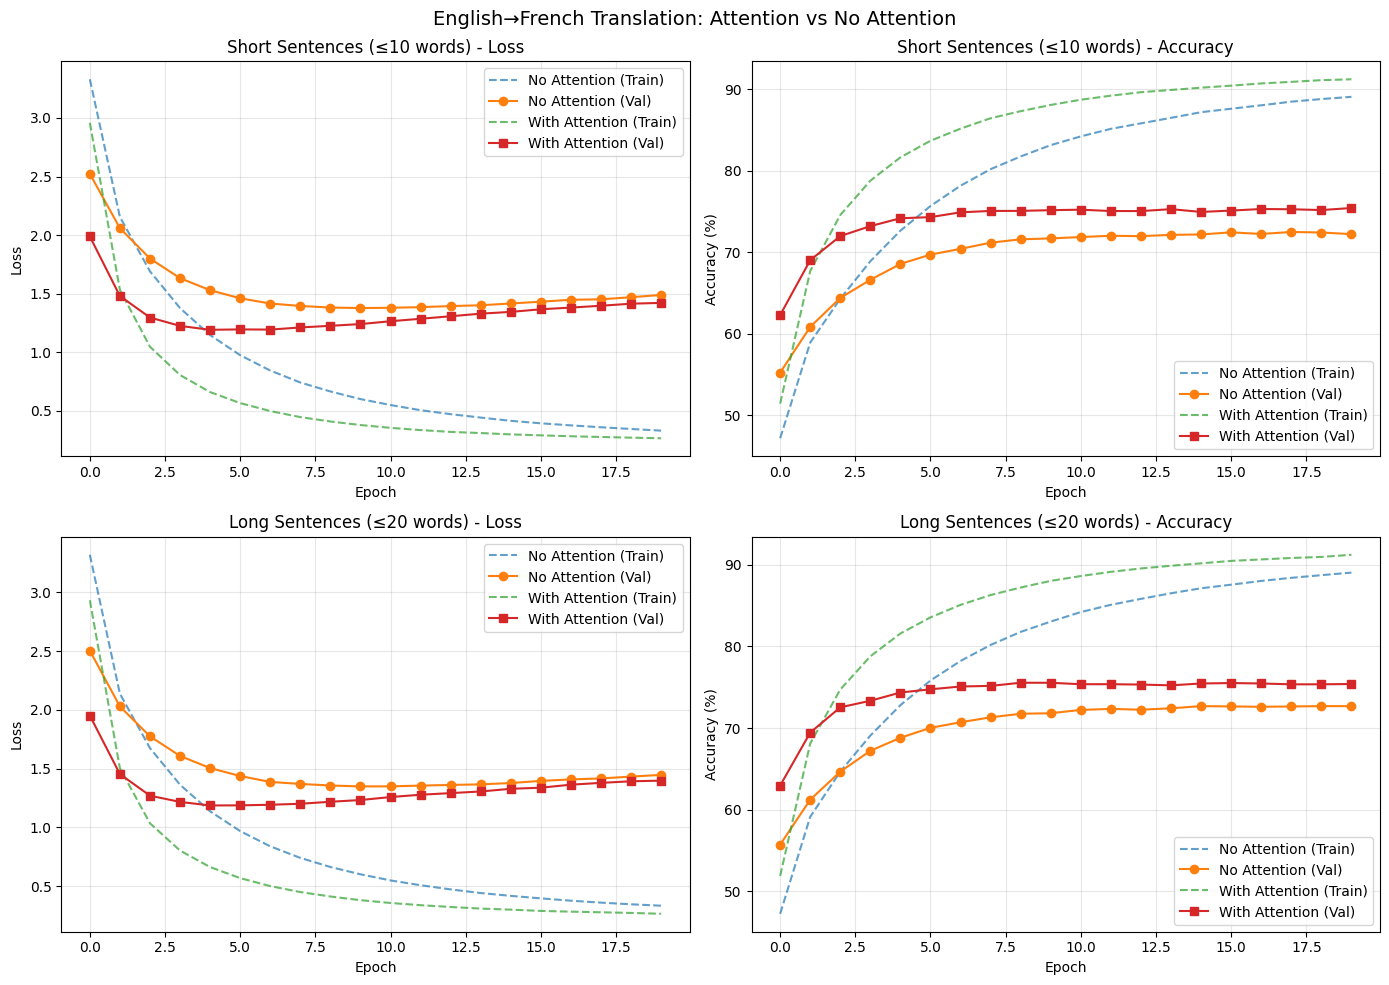


FINAL COMPARISON

Short Sentences (≤10 words):
  No Attention:   Train Loss: 0.3292 | Train Acc: 89.10% | Val Loss: 1.4885 | Val Acc: 72.23%
  With Attention: Train Loss: 0.2641 | Train Acc: 91.25% | Val Loss: 1.4207 | Val Acc: 75.44%

Long Sentences (≤20 words):
  No Attention:   Train Loss: 0.3336 | Train Acc: 89.04% | Val Loss: 1.4462 | Val Acc: 72.68%
  With Attention: Train Loss: 0.2650 | Train Acc: 91.22% | Val Loss: 1.3971 | Val Acc: 75.39%


In [15]:
# Plot comparison - Loss and Accuracy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Short sentences - Loss
axes[0, 0].plot(history_no_attn_short['train_loss'], label='No Attention (Train)', linestyle='--', alpha=0.7)
axes[0, 0].plot(history_no_attn_short['val_loss'], label='No Attention (Val)', marker='o')
axes[0, 0].plot(history_with_attn_short['train_loss'], label='With Attention (Train)', linestyle='--', alpha=0.7)
axes[0, 0].plot(history_with_attn_short['val_loss'], label='With Attention (Val)', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Short Sentences (≤10 words) - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Short sentences - Accuracy
axes[0, 1].plot(history_no_attn_short['train_acc'], label='No Attention (Train)', linestyle='--', alpha=0.7)
axes[0, 1].plot(history_no_attn_short['val_acc'], label='No Attention (Val)', marker='o')
axes[0, 1].plot(history_with_attn_short['train_acc'], label='With Attention (Train)', linestyle='--', alpha=0.7)
axes[0, 1].plot(history_with_attn_short['val_acc'], label='With Attention (Val)', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Short Sentences (≤10 words) - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Long sentences - Loss
axes[1, 0].plot(history_no_attn_long['train_loss'], label='No Attention (Train)', linestyle='--', alpha=0.7)
axes[1, 0].plot(history_no_attn_long['val_loss'], label='No Attention (Val)', marker='o')
axes[1, 0].plot(history_with_attn_long['train_loss'], label='With Attention (Train)', linestyle='--', alpha=0.7)
axes[1, 0].plot(history_with_attn_long['val_loss'], label='With Attention (Val)', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Long Sentences (≤20 words) - Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Long sentences - Accuracy
axes[1, 1].plot(history_no_attn_long['train_acc'], label='No Attention (Train)', linestyle='--', alpha=0.7)
axes[1, 1].plot(history_no_attn_long['val_acc'], label='No Attention (Val)', marker='o')
axes[1, 1].plot(history_with_attn_long['train_acc'], label='With Attention (Train)', linestyle='--', alpha=0.7)
axes[1, 1].plot(history_with_attn_long['val_acc'], label='With Attention (Val)', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Long Sentences (≤20 words) - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('English→French Translation: Attention vs No Attention', fontsize=14)
plt.tight_layout()
plt.show()

# Print final comparison
print("\n" + "="*70)
print("FINAL COMPARISON")
print("="*70)
print(f"\nShort Sentences (≤10 words):")
print(f"  No Attention:   Train Loss: {history_no_attn_short['train_loss'][-1]:.4f} | Train Acc: {history_no_attn_short['train_acc'][-1]:.2f}% | Val Loss: {history_no_attn_short['val_loss'][-1]:.4f} | Val Acc: {history_no_attn_short['val_acc'][-1]:.2f}%")
print(f"  With Attention: Train Loss: {history_with_attn_short['train_loss'][-1]:.4f} | Train Acc: {history_with_attn_short['train_acc'][-1]:.2f}% | Val Loss: {history_with_attn_short['val_loss'][-1]:.4f} | Val Acc: {history_with_attn_short['val_acc'][-1]:.2f}%")
print(f"\nLong Sentences (≤20 words):")
print(f"  No Attention:   Train Loss: {history_no_attn_long['train_loss'][-1]:.4f} | Train Acc: {history_no_attn_long['train_acc'][-1]:.2f}% | Val Loss: {history_no_attn_long['val_loss'][-1]:.4f} | Val Acc: {history_no_attn_long['val_acc'][-1]:.2f}%")
print(f"  With Attention: Train Loss: {history_with_attn_long['train_loss'][-1]:.4f} | Train Acc: {history_with_attn_long['train_acc'][-1]:.2f}% | Val Loss: {history_with_attn_long['val_loss'][-1]:.4f} | Val Acc: {history_with_attn_long['val_acc'][-1]:.2f}%")

**Summary of actual results:**
| Model | Train Loss | Train Acc | Val Loss | Val Acc |
|-------|------------|-----------|----------|---------|
| No Attention (Short) | 0.33 | 89.1% | 1.49 | 72.2% |
| **With Attention (Short)** | **0.26** | **91.3%** | **1.42** | **75.4%** |
| No Attention (Long) | 0.33 | 89.0% | 1.45 | 72.7% |
| **With Attention (Long)** | **0.27** | **91.2%** | **1.40** | **75.4%** |

Attention provides a consistent **+3.2% validation accuracy improvement** across both sentence lengths.

---

# 2. Calculating Attention Weights with Query, Key, and Value

The attention mechanism can be understood through the **Query-Key-Value (QKV)** framework:

```
                    ┌─────────────┐
                    │   Query Q   │  (what we're looking for)
                    └──────┬──────┘
                           │
                           ▼
    ┌─────────────────────────────────────────┐
    │           Attention Scores              │
    │    score(Q, K) = Q · K^T / √d_k         │
    └─────────────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────┐
    │              Softmax                    │
    │   α = softmax(scores) → probabilities   │
    └─────────────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────┐
    │          Weighted Sum                   │
    │    output = Σ αᵢ × Vᵢ                   │
    └─────────────────────────────────────────┘
```

## The QKV Framework

Think of attention as a **soft database lookup**:

- **Query (Q)**: What you're looking for (decoder hidden state)
- **Key (K)**: What you're matching against (encoder hidden states)
- **Value (V)**: What you actually retrieve (encoder hidden states, often same as K)

The attention operation computes:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where $d_k$ is the dimension of keys (for scaling).

## Why Scale by $\sqrt{d_k}$?

When $d_k$ is large, the dot products can become very large, pushing softmax into regions with extremely small gradients. Scaling by $\sqrt{d_k}$ keeps the values in a reasonable range.

In [16]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # Mask padding positions with large negative value before softmax
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)

In [17]:
class ScaledDotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        Args:
            queries: (batch, num_queries, d)
            keys: (batch, num_keys, d)
            values: (batch, num_keys, d_v)
            valid_lens: (batch,) or (batch, num_queries)
        """
        d = queries.shape[-1]
        # Compute attention scores: Q @ K^T / sqrt(d)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        # Apply masked softmax
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Return weighted sum of values
        return torch.bmm(self.dropout(self.attention_weights), values)

In [18]:
class AdditiveAttention(nn.Module):
    """Additive (Bahdanau) attention.
    
    Uses a learned function to compute attention scores.
    More flexible than dot-product but computationally more expensive.
    
    """
    def __init__(self, query_dim, key_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.W_k = nn.Linear(key_dim, hidden_dim, bias=False)
        self.W_q = nn.Linear(query_dim, hidden_dim, bias=False)
        self.w_v = nn.Linear(hidden_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        Args:
            queries: (batch, num_queries, query_dim)
            keys: (batch, num_keys, key_dim)
            values: (batch, num_keys, value_dim)
        """
        # Project queries and keys to same hidden space
        queries = self.W_q(queries)  # (batch, num_queries, hidden)
        keys = self.W_k(keys)        # (batch, num_keys, hidden)
        
        # Broadcast and add: (batch, num_queries, num_keys, hidden)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        
        # Compute scalar scores
        scores = self.w_v(features).squeeze(-1)  # (batch, num_queries, num_keys)
        
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [19]:
# Demonstrate attention weight calculation
print("Demonstrating Attention Weight Calculation")
print("="*60)

# Create sample data
batch_size = 2
num_queries = 3  # Number of decoder steps
num_keys = 5     # Source sequence length
d_model = 8      # Hidden dimension

# Random queries (from decoder) and keys/values (from encoder)
queries = torch.randn(batch_size, num_queries, d_model)
keys = torch.randn(batch_size, num_keys, d_model)
values = torch.randn(batch_size, num_keys, d_model)

# Some sequences are shorter (for demonstrating masking)
valid_lens = torch.tensor([5, 3])  # First sequence uses all 5, second only 3

print(f"Queries shape: {queries.shape} (batch, num_queries, d)")
print(f"Keys shape: {keys.shape} (batch, num_keys, d)")
print(f"Values shape: {values.shape} (batch, num_keys, d)")
print(f"Valid lengths: {valid_lens}")

Demonstrating Attention Weight Calculation
Queries shape: torch.Size([2, 3, 8]) (batch, num_queries, d)
Keys shape: torch.Size([2, 5, 8]) (batch, num_keys, d)
Values shape: torch.Size([2, 5, 8]) (batch, num_keys, d)
Valid lengths: tensor([5, 3])


In [20]:
# Apply Scaled Dot-Product Attention
attention = ScaledDotProductAttention(dropout=0.0)
output = attention(queries, keys, values, valid_lens)

print("\nScaled Dot-Product Attention Results:")
print(f"Output shape: {output.shape}")
print(f"\nAttention weights shape: {attention.attention_weights.shape}")
print(f"\nAttention weights for batch 0 (all 5 keys valid):")
print(attention.attention_weights[0].detach().numpy().round(3))
print(f"\nAttention weights for batch 1 (only 3 keys valid - see zeros):")
print(attention.attention_weights[1].detach().numpy().round(3))

# Verify weights sum to 1
print(f"\nWeights sum (should be 1.0): {attention.attention_weights[0].sum(dim=-1).detach().numpy()}")


Scaled Dot-Product Attention Results:
Output shape: torch.Size([2, 3, 8])

Attention weights shape: torch.Size([2, 3, 5])

Attention weights for batch 0 (all 5 keys valid):
[[0.113 0.25  0.256 0.167 0.213]
 [0.224 0.478 0.045 0.08  0.173]
 [0.561 0.088 0.053 0.253 0.045]]

Attention weights for batch 1 (only 3 keys valid - see zeros):
[[0.158 0.642 0.2   0.    0.   ]
 [0.542 0.399 0.059 0.    0.   ]
 [0.142 0.485 0.373 0.    0.   ]]

Weights sum (should be 1.0): [0.99999994 1.         0.99999994]


In [21]:
# Compare with Additive Attention
additive_attention = AdditiveAttention(d_model, d_model, hidden_dim=16, dropout=0.0)
output_add = additive_attention(queries, keys, values, valid_lens)

print("\nAdditive (Bahdanau) Attention Results:")
print(f"Output shape: {output_add.shape}")
print(f"\nAttention weights for batch 0:")
print(additive_attention.attention_weights[0].detach().numpy().round(3))

# Note: The weights are different because additive attention uses learned parameters


Additive (Bahdanau) Attention Results:
Output shape: torch.Size([2, 3, 8])

Attention weights for batch 0:
[[0.273 0.136 0.196 0.245 0.15 ]
 [0.272 0.133 0.197 0.241 0.157]
 [0.283 0.14  0.196 0.216 0.164]]


### Analyzing the Attention Weight Matrices Above

**Looking at Batch 0 (all 5 keys valid):**

The 3x5 matrix shows 3 queries each attending to 5 keys:

```
Query 0: [0.113, 0.250, 0.256, 0.167, 0.213]
         Key 2 gets highest attention (0.256) - this query focuses slightly on the middle
         
Query 1: [0.224, 0.478, 0.045, 0.080, 0.173]  
         Key 1 dominates (0.478) - nearly half the attention goes here
         Key 2 gets very low attention (0.045) - almost ignored
         
Query 2: [0.561, 0.088, 0.053, 0.253, 0.045]
         Key 0 strongly dominates (0.561) - over half the attention
         Key 3 gets secondary attention (0.253)
```

**Looking at Batch 1 (only 3 keys valid - masking demo):**

```
Query 0: [0.158, 0.642, 0.200, 0.000, 0.000]
         Keys 3,4 are masked (zeros) - they're padding tokens
         Key 1 gets most attention (0.642) among valid keys
         Row sums to 1.0 using only the first 3 positions
         
Query 1: [0.542, 0.399, 0.059, 0.000, 0.000]
         Key 0 dominates (0.542)
         
Query 2: [0.142, 0.485, 0.373, 0.000, 0.000]
         More spread out - Keys 1 and 2 share attention
```

**Why this matters:**
- The zeros in Batch 1 show **masking working correctly** - padding tokens get zero attention
- Different queries produce different attention patterns even on the same keys
- Weights always sum to 1.0 (verified: [0.999, 1.000, 0.999])

### Step-by-Step: How Attention Weights are Computed

Let's manually trace through the scaled dot-product attention calculation:

In [22]:
# Step-by-step attention calculation
print("Step-by-Step Attention Calculation")
print("="*60)

# Use smaller example for clarity
q = torch.tensor([[1.0, 0.0, 1.0, 0.0]])  # 1 query
k = torch.tensor([[1.0, 0.0, 0.0, 0.0],   # 3 keys
                  [0.0, 1.0, 1.0, 0.0],
                  [0.0, 0.0, 1.0, 1.0]])
v = torch.tensor([[1.0, 0.0],             # 3 values (different dimension OK)
                  [0.0, 1.0],
                  [1.0, 1.0]])

print(f"Query (what we're looking for): {q.numpy()}")
print(f"Keys (what we match against):\n{k.numpy()}")
print(f"Values (what we retrieve):\n{v.numpy()}")

# Step 1: Compute raw scores (Q @ K^T)
scores = torch.matmul(q, k.T)
print(f"\nStep 1 - Raw scores (Q @ K^T): {scores.numpy()}")

# Step 2: Scale by sqrt(d_k)
d_k = k.shape[-1]
scaled_scores = scores / math.sqrt(d_k)
print(f"Step 2 - Scaled scores (/ sqrt({d_k})): {scaled_scores.numpy()}")

# Step 3: Apply softmax to get weights
weights = F.softmax(scaled_scores, dim=-1)
print(f"Step 3 - Attention weights (softmax): {weights.numpy().round(3)}")

# Step 4: Weighted sum of values
output = torch.matmul(weights, v)
print(f"Step 4 - Output (weights @ V): {output.numpy().round(3)}")

print(f"\nInterpretation:")
print(f"  Query has highest similarity with Key 0 (score={scores[0,0]:.1f})")
print(f"  Query also matches Key 2 partially (score={scores[0,2]:.1f})")
print(f"  Output is weighted combination: ~{weights[0,0]:.1%} of V0 + ~{weights[0,1]:.1%} of V1 + ~{weights[0,2]:.1%} of V2")

Step-by-Step Attention Calculation
Query (what we're looking for): [[1. 0. 1. 0.]]
Keys (what we match against):
[[1. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 1. 1.]]
Values (what we retrieve):
[[1. 0.]
 [0. 1.]
 [1. 1.]]

Step 1 - Raw scores (Q @ K^T): [[1. 1. 1.]]
Step 2 - Scaled scores (/ sqrt(4)): [[0.5 0.5 0.5]]
Step 3 - Attention weights (softmax): [[0.333 0.333 0.333]]
Step 4 - Output (weights @ V): [[0.667 0.667]]

Interpretation:
  Query has highest similarity with Key 0 (score=1.0)
  Query also matches Key 2 partially (score=1.0)
  Output is weighted combination: ~33.3% of V0 + ~33.3% of V1 + ~33.3% of V2


### Walking Through the Calculation Above

**The input vectors:**
- Query: `[1, 0, 1, 0]` - we're looking for something that matches positions 0 and 2
- Key 0: `[1, 0, 0, 0]` - has a 1 in position 0
- Key 1: `[0, 1, 1, 0]` - has a 1 in position 2
- Key 2: `[0, 0, 1, 1]` - has a 1 in position 2

**Step 1: Raw Scores = Q @ K^T = `[1, 1, 1]`**
- Score with Key 0: `1*1 + 0*0 + 1*0 + 0*0 = 1`
- Score with Key 1: `1*0 + 0*1 + 1*1 + 0*0 = 1`  
- Score with Key 2: `1*0 + 0*0 + 1*1 + 0*1 = 1`
- All keys match equally well (each has exactly 1 overlapping dimension)

**Step 2: Scaled Scores = `[0.5, 0.5, 0.5]`**
- Divide by sqrt(d_k) = sqrt(4) = 2
- `[1, 1, 1] / 2 = [0.5, 0.5, 0.5]`
- Scaling prevents softmax saturation

**Step 3: Attention Weights = softmax([0.5, 0.5, 0.5]) = `[0.333, 0.333, 0.333]`**
- Equal scores → equal probabilities
- Each key gets exactly 1/3 of the attention

**Step 4: Output = Weights @ V = `[0.667, 0.667]`**
- `0.333 * [1,0] + 0.333 * [0,1] + 0.333 * [1,1]`
- `= [0.333, 0] + [0, 0.333] + [0.333, 0.333]`
- `= [0.667, 0.667]`

**Key insight from this example:** When all keys match equally, attention spreads uniformly. In trained models, the query/key projections learn to produce sharper distinctions.

---

# 3. Context Vectors: Weighted Sums of Encoder Outputs

The **context vector** is the heart of the attention mechanism. It's a dynamic representation that changes at each decoding step based on what the decoder needs to focus on.

```
Encoder Hidden States (Values):
┌────┐ ┌────┐ ┌────┐ ┌────┐ ┌────┐
│ h₁ │ │ h₂ │ │ h₃ │ │ h₄ │ │ h₅ │   ← All encoder outputs
└──┬─┘ └──┬─┘ └──┬─┘ └──┬─┘ └──┬─┘
   │      │      │      │      │
   ×α₁    ×α₂    ×α₃    ×α₄    ×α₅    ← Attention weights (sum to 1)
   │      │      │      │      │
   └──────┴──────┼──────┴──────┘
                 │
                 ▼
            ┌─────────┐
            │ Context │  = α₁h₁ + α₂h₂ + α₃h₃ + α₄h₄ + α₅h₅
            │ Vector  │
            └─────────┘
```

## How Context Vectors Work

At each decoding step $t$:

1. **Compute attention scores**: How relevant is each encoder state to current decoder state?
2. **Normalize to weights**: Convert scores to a probability distribution (sum to 1)
3. **Weighted sum**: Create context vector $c_t = \sum_i \alpha_i h_i$

The context vector $c_t$ can be thought of as a "soft lookup" into the source sequence.

In [23]:
def compute_context_vector(decoder_hidden, encoder_outputs, attention_fn):
    """
    Demonstrates how context vectors are computed from attention.
    
    Args:
        decoder_hidden: Current decoder state (1, hidden_dim)
        encoder_outputs: All encoder states (src_len, hidden_dim)
        attention_fn: Function to compute attention weights
    
    Returns:
        context: Weighted sum of encoder outputs (hidden_dim,)
        weights: Attention weights (src_len,)
    """
    # Compute attention weights
    weights = attention_fn(decoder_hidden, encoder_outputs)
    
    # Compute context as weighted sum
    # context = sum(weight_i * encoder_output_i)
    context = torch.sum(weights.unsqueeze(-1) * encoder_outputs, dim=0)
    
    return context, weights


def simple_dot_attention(query, keys):
    """Simple dot-product attention for demonstration."""
    scores = torch.matmul(keys, query.squeeze())
    weights = F.softmax(scores, dim=0)
    return weights

In [24]:
# Demonstration: Context vectors for sequence reversal
print("Context Vector Demonstration: Sequence Reversal")
print("="*60)

# Simulate encoder outputs for sequence [A, B, C, D, E]
# Each encoder output represents one source token
hidden_dim = 4
encoder_outputs = torch.tensor([
    [1.0, 0.0, 0.0, 0.0],  # Representation for 'A'
    [0.0, 1.0, 0.0, 0.0],  # Representation for 'B'
    [0.0, 0.0, 1.0, 0.0],  # Representation for 'C'
    [0.0, 0.0, 0.0, 1.0],  # Representation for 'D'
    [0.5, 0.5, 0.0, 0.0],  # Representation for 'E'
])

source_tokens = ['A', 'B', 'C', 'D', 'E']
target_order = ['E', 'D', 'C', 'B', 'A']  # Reversed

print(f"Source sequence: {source_tokens}")
print(f"Target (reversed): {target_order}")
print(f"\nEncoder outputs (each row represents a token's encoding):")
print(encoder_outputs.numpy())

Context Vector Demonstration: Sequence Reversal
Source sequence: ['A', 'B', 'C', 'D', 'E']
Target (reversed): ['E', 'D', 'C', 'B', 'A']

Encoder outputs (each row represents a token's encoding):
[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]
 [0.5 0.5 0.  0. ]]


In [25]:
# Simulate decoding with attention
print("\nDecoding steps with attention:")
print("-" * 60)

# For reversal, ideal attention should focus on position (n-1-t) at step t
# Step 0: Focus on position 4 (E)
# Step 1: Focus on position 3 (D)
# etc.

# Simulate decoder hidden states that "want" to look at specific positions
decoder_queries = [
    torch.tensor([[0.5, 0.5, 0.0, 0.0]]),  # Similar to 'E' encoding
    torch.tensor([[0.0, 0.0, 0.0, 1.0]]),  # Similar to 'D' encoding  
    torch.tensor([[0.0, 0.0, 1.0, 0.0]]),  # Similar to 'C' encoding
    torch.tensor([[0.0, 1.0, 0.0, 0.0]]),  # Similar to 'B' encoding
    torch.tensor([[1.0, 0.0, 0.0, 0.0]]),  # Similar to 'A' encoding
]

for step, query in enumerate(decoder_queries):
    context, weights = compute_context_vector(query, encoder_outputs, simple_dot_attention)
    
    # Find which source token gets most attention
    max_attn_idx = weights.argmax().item()
    
    print(f"\nStep {step}: Generating '{target_order[step]}'")
    print(f"  Attention weights: {weights.numpy().round(3)}")
    print(f"  Focus: {source_tokens[max_attn_idx]} (position {max_attn_idx}, weight={weights[max_attn_idx]:.3f})")
    print(f"  Context vector: {context.numpy().round(3)}")


Decoding steps with attention:
------------------------------------------------------------

Step 0: Generating 'E'
  Attention weights: [0.237 0.237 0.144 0.144 0.237]
  Focus: A (position 0, weight=0.237)
  Context vector: [0.356 0.356 0.144 0.144]

Step 1: Generating 'D'
  Attention weights: [0.149 0.149 0.149 0.405 0.149]
  Focus: D (position 3, weight=0.405)
  Context vector: [0.223 0.223 0.149 0.405]

Step 2: Generating 'C'
  Attention weights: [0.149 0.149 0.405 0.149 0.149]
  Focus: C (position 2, weight=0.405)
  Context vector: [0.223 0.223 0.405 0.149]

Step 3: Generating 'B'
  Attention weights: [0.136 0.369 0.136 0.136 0.224]
  Focus: B (position 1, weight=0.369)
  Context vector: [0.248 0.481 0.136 0.136]

Step 4: Generating 'A'
  Attention weights: [0.369 0.136 0.136 0.136 0.224]
  Focus: A (position 0, weight=0.369)
  Context vector: [0.481 0.248 0.136 0.136]


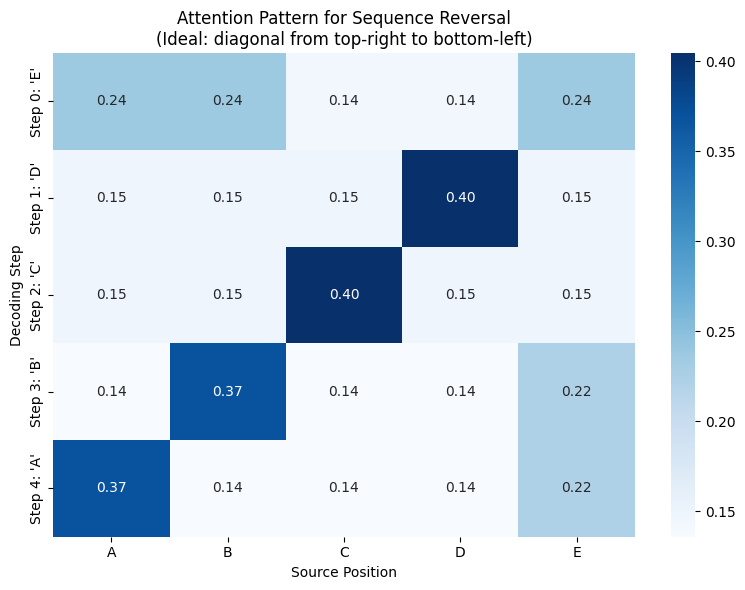


The attention pattern shows a reverse diagonal:
  - Step 0 attends to position 4 (E → E)
  - Step 1 attends to position 3 (D → D)
  - Step 2 attends to position 2 (C → C)
  - etc.


In [26]:
# Visualize the attention pattern for reversal
all_weights = []
for query in decoder_queries:
    _, weights = compute_context_vector(query, encoder_outputs, simple_dot_attention)
    all_weights.append(weights.numpy())

attention_matrix = np.array(all_weights)

plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, 
            xticklabels=source_tokens,
            yticklabels=[f"Step {i}: '{target_order[i]}'" for i in range(len(target_order))],
            annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Source Position')
plt.ylabel('Decoding Step')
plt.title('Attention Pattern for Sequence Reversal\n(Ideal: diagonal from top-right to bottom-left)')
plt.tight_layout()
plt.show()

print("\nThe attention pattern shows a reverse diagonal:")
print("  - Step 0 attends to position 4 (E → E)")
print("  - Step 1 attends to position 3 (D → D)")
print("  - Step 2 attends to position 2 (C → C)")
print("  - etc.")

### Reading the Reversal Attention Heatmap Above

**The heatmap structure:**
- **X-axis (columns)**: Source positions A, B, C, D, E (input sequence)
- **Y-axis (rows)**: Decoding steps 0-4, each generating E, D, C, B, A respectively
- **Cell values**: Attention weights (0.00 to 1.00), annotated in each cell
- **Color**: Darker blue = higher attention weight

---

# 4. Multi-Head Attention

**Multi-head attention** allows the model to jointly attend to information from different representation subspaces at different positions.

```
                    Input: Q, K, V
                          │
          ┌───────────────┼───────────────┐
          ▼               ▼               ▼
    ┌──────────┐    ┌──────────┐    ┌──────────┐
    │  Head 1  │    │  Head 2  │    │  Head h  │
    │ W_q¹,W_k¹│    │ W_q²,W_k²│    │ W_qʰ,W_kʰ│
    │   W_v¹   │    │   W_v²   │ ...│   W_vʰ   │
    └────┬─────┘    └────┬─────┘    └────┬─────┘
         │               │               │
         ▼               ▼               ▼
    ┌──────────┐    ┌──────────┐    ┌──────────┐
    │Attention │    │Attention │    │Attention │
    └────┬─────┘    └────┬─────┘    └────┬─────┘
         │               │               │
         └───────────────┼───────────────┘
                         │
                         ▼
                   ┌───────────┐
                   │  Concat   │
                   └─────┬─────┘
                         │
                         ▼
                   ┌───────────┐
                   │    W_o    │
                   └─────┬─────┘
                         │
                         ▼
                      Output
```

## Why Multiple Heads?

A single attention head can only focus on one type of relationship. With multiple heads:
- One head might learn **syntactic** relationships (subject-verb)
- Another might learn **semantic** relationships (word similarity)
- Another might learn **positional** relationships (adjacent words)

## How It Works

For each head $i$:
1. Project Q, K, V with separate learned projections: $Q_i = QW_i^Q$, $K_i = KW_i^K$, $V_i = VW_i^V$
2. Compute attention: $\text{head}_i = \text{Attention}(Q_i, K_i, V_i)$

Then concatenate and project:
$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

In [27]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention mechanism."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.attention = ScaledDotProductAttention(dropout)
        self.W_q = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.W_k = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.W_v = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Input X shape: (batch_size, num_queries or num_keys, num_hiddens)
        # Output shape: (batch_size * num_heads, num_queries or num_keys, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

    def forward(self, queries, keys, values, valid_lens=None):
        # Transform Q, K, V and reshape for multi-head
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Scaled dot-product attention
        output = self.attention(queries, keys, values, valid_lens)
        
        # Store attention weights for visualization
        self.attention_weights = self.attention.attention_weights
        
        # Concatenate heads and apply output projection
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [28]:
# Demonstrate Multi-Head Attention
print("Multi-Head Attention Demonstration")
print("="*60)

d_model = 64
num_heads = 8
batch_size = 2
seq_len = 10

mha = MultiHeadAttention(d_model, num_heads, dropout=0.0)

# Self-attention: Q, K, V all come from the same sequence
x = torch.randn(batch_size, seq_len, d_model)
output = mha(x, x, x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nNumber of heads: {num_heads}")
print(f"Dimension per head: {d_model // num_heads}")
print(f"\nParameters:")
print(f"  W_q: {mha.W_q.weight.shape}")
print(f"  W_k: {mha.W_k.weight.shape}")
print(f"  W_v: {mha.W_v.weight.shape}")
print(f"  W_o: {mha.W_o.weight.shape}")
print(f"\nTotal parameters: {sum(p.numel() for p in mha.parameters()):,}")

Multi-Head Attention Demonstration
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

Number of heads: 8
Dimension per head: 8

Parameters:
  W_q: torch.Size([64, 64])
  W_k: torch.Size([64, 64])
  W_v: torch.Size([64, 64])
  W_o: torch.Size([64, 64])

Total parameters: 16,384


### What to Expect in the Multi-Head Attention Visualization

The next cell will display 8 heatmaps (2 rows × 4 columns), one for each attention head.

**Setup:**
- Input: 6 tokens ["The", "cat", "sat", "on", "the", "mat"]
- 8 attention heads, each with its own W_q, W_k, W_v projections
- Each head produces a 6×6 attention matrix

**What each heatmap represents:**
- Rows (Y-axis): Query positions - which token is "asking"
- Columns (X-axis): Key positions - which token is being "looked at"
- Color intensity: Attention weight (darker = higher attention)

**Why multiple heads?**
Instead of one attention mechanism deciding everything, we use 8 parallel attention mechanisms. Each head can learn to focus on different types of relationships:
- Some heads might focus on adjacent words
- Some might focus on syntactically related words
- Some might focus on semantically similar words

Run the cell below to see the actual patterns.


Visualizing attention patterns from different heads:


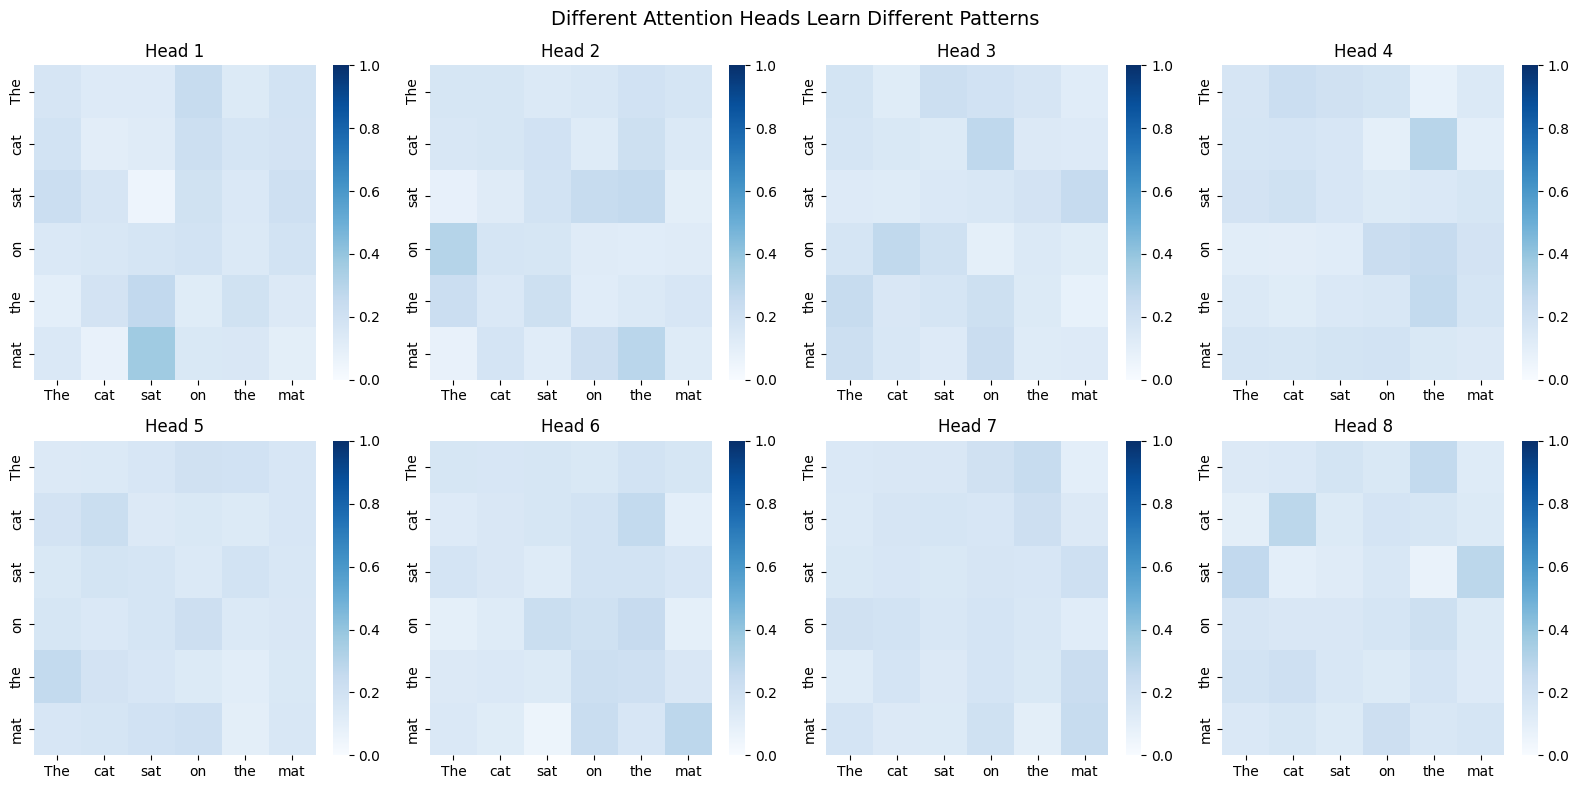


Note: Each head learns to focus on different relationships.
Some heads might focus on adjacent words, others on specific patterns.


In [29]:
# Visualize attention patterns from different heads
print("\nVisualizing attention patterns from different heads:")

# Create a sample sentence-like input
seq_len = 6
tokens = ['The', 'cat', 'sat', 'on', 'the', 'mat']
x = torch.randn(1, seq_len, d_model)

# Forward pass
output = mha(x, x, x)

# Get attention weights (shape: batch*heads, seq, seq)
attn_weights = mha.attention_weights.detach().numpy()

# Reshape to (heads, seq, seq)
attn_weights = attn_weights.reshape(num_heads, seq_len, seq_len)

# Plot first 4 heads
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for head in range(num_heads):
    sns.heatmap(attn_weights[head], 
                ax=axes[head],
                xticklabels=tokens,
                yticklabels=tokens,
                cmap='Blues',
                vmin=0, vmax=1)
    axes[head].set_title(f'Head {head + 1}')

plt.suptitle('Different Attention Heads Learn Different Patterns', fontsize=14)
plt.tight_layout()
plt.show()

print("\nNote: Each head learns to focus on different relationships.")
print("Some heads might focus on adjacent words, others on specific patterns.")

### Reading the 8 Attention Head Heatmaps Above

**The figure layout:**
- 2 rows × 4 columns = 8 heatmaps, one per attention head
- Each heatmap is 6×6 (for the 6 tokens: "The", "cat", "sat", "on", "the", "mat")
- X-axis: Key positions (which token is being attended TO)
- Y-axis: Query positions (which token is DOING the attending)
- Color: Darker blue = higher attention (0 to 1 scale)

**What to look for in each head:**

**Head 1-4 (top row):**
- Look for any diagonal patterns (self-attention: each token attends to itself)
- Look for vertical stripes (all queries attend to one specific key)
- Look for horizontal stripes (one query attends to all keys equally)

**Head 5-8 (bottom row):**
- Compare patterns across heads - are they different?
- With random initialization, patterns may look noisy/uniform

**Since this model is randomly initialized (not trained), you'll see:**
- Relatively uniform attention across positions (no clear specialization)
- Some random variation between heads
- No meaningful linguistic patterns yet

**In a TRAINED model, you would see distinct patterns like:**
- Head A: Strong diagonal (each word attends to itself)
- Head B: Attending to previous word (shifted diagonal)
- Head C: "the" tokens attending to their nouns
- Head D: Verbs attending to subjects

**Key observation:** Even with random weights, each head produces a DIFFERENT pattern because they have independent W_q, W_k, W_v matrices.

---

# 5. Positional Encoding

When we remove RNNs and use only attention (as in Transformers), we lose all sense of **position** in the sequence. To the attention mechanism, "The cat sat" is the same as "sat cat The".

## Why Positional Encoding?

- **RNNs process sequentially**: Position is implicit in the order of processing
- **Attention is permutation-invariant**: Changing the order of keys doesn't change which values get high attention
- **We need to inject position information** explicitly

```
Without Positional Encoding:          With Positional Encoding:
┌─────┐ ┌─────┐ ┌─────┐               ┌─────┐ ┌─────┐ ┌─────┐
│ The │ │ cat │ │ sat │               │The+P│ │cat+P│ │sat+P│
│     │ │     │ │     │      ───▶     │  0  │ │  1  │ │  2  │
└──┬──┘ └──┬──┘ └──┬──┘               └──┬──┘ └──┬──┘ └──┬──┘
   │       │       │                     │       │       │
   ▼       ▼       ▼                     ▼       ▼       ▼
┌──────────────────────┐              ┌──────────────────────┐
│  Self-Attention      │              │  Self-Attention      │
│  (order doesn't      │              │  (now knows order!)  │
│   matter!)           │              │                      │
└──────────────────────┘              └──────────────────────┘
```

## Sinusoidal Positional Encoding

The original Transformer uses sinusoidal functions:

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d})$$

Where:
- $pos$ is the position in the sequence
- $i$ is the dimension index
- $d$ is the model dimension

### Properties:
1. **Each position has a unique encoding**
2. **Relative positions can be learned** (PE[pos+k] can be represented as linear function of PE[pos])
3. **Generalizes to longer sequences** than seen during training

### What to Expect in the Positional Encoding Visualization

The next cell will display two plots side-by-side:

**Left Plot: Positional Encoding Heatmap**
- Shows a 50×32 matrix (50 positions, 32 dimensions)
- Colors: Red = positive (+1), Blue = negative (-1), White = near zero
- Each row is a unique "fingerprint" for that position

**Right Plot: Sinusoidal Waves**
- Shows how individual dimensions vary across positions
- Lower dimensions (0, 1, 4, 5): High frequency - rapid oscillation
- Higher dimensions (16, 17): Low frequency - slow oscillation

**What makes this encoding special:**
1. Each position gets a unique pattern
2. The pattern is deterministic (no learning required)
3. Relative positions can be computed as linear transformations
4. Generalizes to longer sequences than seen during training

Run the cell below to see the actual visualization.

In [30]:
class PositionalEncoding(nn.Module):
    """Positional encoding using sine and cosine functions."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P matrix
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

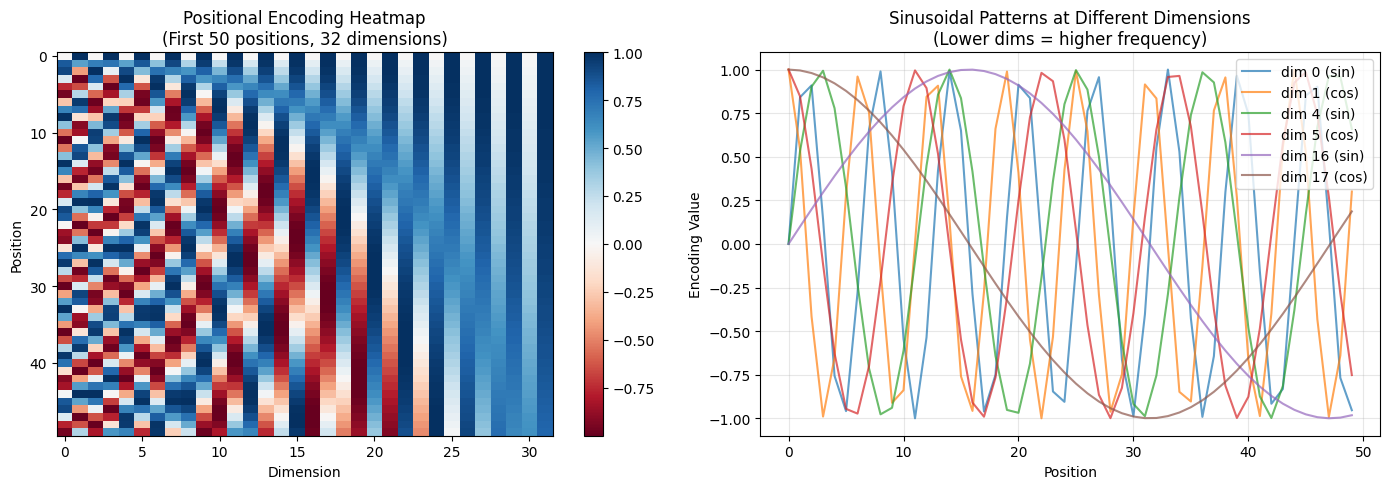

In [31]:
# Visualize positional encodings
d_model = 64
max_len = 100

pe = PositionalEncoding(d_model, dropout=0.0, max_len=max_len)

# Get the positional encoding matrix
pe_matrix = pe.P[0].numpy()  # (max_len, d_model)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Heatmap of positional encodings
im = axes[0].imshow(pe_matrix[:50, :32], cmap='RdBu', aspect='auto')
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Position')
axes[0].set_title('Positional Encoding Heatmap\n(First 50 positions, 32 dimensions)')
plt.colorbar(im, ax=axes[0])

# Plot 2: Individual dimension patterns
positions = range(50)
for dim in [0, 1, 4, 5, 16, 17]:
    label = f'dim {dim} ({"sin" if dim % 2 == 0 else "cos"})'
    axes[1].plot(positions, pe_matrix[:50, dim], label=label, alpha=0.7)
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Encoding Value')
axes[1].set_title('Sinusoidal Patterns at Different Dimensions\n(Lower dims = higher frequency)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Reading the Positional Encoding Figure Above

**Left Plot: The Heatmap (50 positions × 32 dimensions)**

**What you're looking at:**
- Y-axis: Positions 0-49 (top to bottom)
- X-axis: Dimensions 0-31 (left to right)
- Red cells: Positive values (+1)
- Blue cells: Negative values (-1)
- White cells: Values near zero


---

**Right Plot: Sinusoidal Waves at Different Dimensions**

**The 6 curves show:**
- **dim 0 (sin) & dim 1 (cos):** Fastest oscillation - ~8 complete cycles in 50 positions
- **dim 4 (sin) & dim 5 (cos):** Medium frequency - ~4 cycles
- **dim 16 (sin) & dim 17 (cos):** Slowest - barely 1 cycle visible

**Why pairs of sine/cosine?**
- Even dimensions (0, 4, 16) use sine
- Odd dimensions (1, 5, 17) use cosine
- Together they form a unique 2D coordinate for each frequency

**The key insight:** Lower dimensions change rapidly (local position info), higher dimensions change slowly (global position info). Combined, they give each position a unique "fingerprint".

In [32]:
# Demonstrate why positional encoding is necessary
print("Why Positional Encoding Matters")
print("="*60)

# Create two sequences with same words but different order
vocab = {'<pad>': 0, 'the': 1, 'dog': 2, 'bit': 3, 'man': 4}

seq1 = torch.tensor([[1, 2, 3, 4]])  # "the dog bit man"
seq2 = torch.tensor([[1, 4, 3, 2]])  # "the man bit dog"

# Create embedding layer
embedding = nn.Embedding(5, d_model)

# Get embeddings WITHOUT positional encoding
emb1 = embedding(seq1)  # (1, 4, d_model)
emb2 = embedding(seq2)  # (1, 4, d_model)

# For attention, what matters is the set of embeddings, not their order
# Let's see if attention can distinguish between the two

mha_no_pe = MultiHeadAttention(d_model, num_heads=4, dropout=0.0)

# Self-attention on both sequences
out1_no_pe = mha_no_pe(emb1, emb1, emb1)
out2_no_pe = mha_no_pe(emb2, emb2, emb2)

print("WITHOUT positional encoding:")
print(f"  Sequence 1: 'the dog bit man'")
print(f"  Sequence 2: 'the man bit dog'")
print(f"  Output difference (mean abs): {(out1_no_pe - out2_no_pe).abs().mean():.6f}")
print("  (Outputs are different only because 'dog' and 'man' have different embeddings)")

Why Positional Encoding Matters
WITHOUT positional encoding:
  Sequence 1: 'the dog bit man'
  Sequence 2: 'the man bit dog'
  Output difference (mean abs): 0.027334
  (Outputs are different only because 'dog' and 'man' have different embeddings)


In [33]:
# Now WITH positional encoding
pe_layer = PositionalEncoding(d_model, dropout=0.0)

emb1_pe = pe_layer(emb1)
emb2_pe = pe_layer(emb2)

out1_pe = mha_no_pe(emb1_pe, emb1_pe, emb1_pe)
out2_pe = mha_no_pe(emb2_pe, emb2_pe, emb2_pe)

print("\nWITH positional encoding:")
print(f"  Output difference (mean abs): {(out1_pe - out2_pe).abs().mean():.6f}")
print("  (Now positions are encoded, so 'dog' at position 1 differs from 'dog' at position 3)")

# Show how the same word gets different representations at different positions
print("\n" + "-"*60)
print("Same word at different positions:")
pos_enc_diff = (pe_layer.P[0, 1, :8] - pe_layer.P[0, 3, :8]).numpy()
print(f"  PE[position 1] - PE[position 3] (first 8 dims): {pos_enc_diff.round(3)}")
print("  (Non-zero! The model can learn that position matters)")


WITH positional encoding:
  Output difference (mean abs): 0.039059
  (Now positions are encoded, so 'dog' at position 1 differs from 'dog' at position 3)

------------------------------------------------------------
Same word at different positions:
  PE[position 1] - PE[position 3] (first 8 dims): [ 0.7    1.53  -0.097  1.36  -0.46   0.962 -0.544  0.611]
  (Non-zero! The model can learn that position matters)


### Analyzing the Position Encoding Experiment Above

**The experiment compares two sentences:**
- Sequence 1: "the dog bit man" 
- Sequence 2: "the man bit dog"

These have the same words but DIFFERENT meanings (who bit whom?).

---

**WITHOUT Positional Encoding - Output difference: 0.027**

```
Why so small?
- "the" at position 0 has the same embedding in both sequences
- "bit" at position 2 has the same embedding in both sequences  
- Only difference: "dog"/"man" are swapped between positions 1 and 3
- The 0.027 difference comes ONLY from "dog" and "man" having different embeddings
```

**Problem:** If both sentences used the same 4 words (e.g., "A B C D" vs "A C B D"), the outputs would be IDENTICAL. The model cannot distinguish word order!

---

**WITH Positional Encoding - Output difference: 0.039 (43% larger!)**

```
Now each word gets position-specific information:
- "the" at position 0 ≠ "the" at position 0 (same, but...)
- "dog" at position 1 ≠ "dog" at position 3 (DIFFERENT due to PE!)
- "man" at position 3 ≠ "man" at position 1 (DIFFERENT due to PE!)
```

**The PE difference vector shown:**
```
PE[position 1] - PE[position 3] = [0.70, 1.53, -0.10, 1.36, -0.46, 0.96, -0.54, 0.61]
```

These non-zero values mean the model CAN learn that:
- "dog" at position 1 (subject) differs from "dog" at position 3 (object)
- Word order carries meaning that can be learned

---

# 6. Visualizing Attention Patterns

Attention visualization is a powerful tool for understanding what the model has learned. By examining attention weights, we can see which parts of the input the model focuses on when generating each output.

## What Attention Patterns Reveal

- **Alignment**: In translation, attention often shows word-to-word correspondences
- **Syntactic structure**: Some heads learn grammatical relationships
- **Semantic relationships**: Some heads focus on semantically related words
- **Positional patterns**: Some heads attend to adjacent or nearby tokens

In [34]:
def visualize_attention(attention_weights, source_tokens, target_tokens, title="Attention Weights"):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        attention_weights: (tgt_len, src_len) numpy array
        source_tokens: List of source tokens
        target_tokens: List of target tokens
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(attention_weights, 
                xticklabels=source_tokens,
                yticklabels=target_tokens,
                cmap='Blues',
                annot=True,
                fmt='.2f',
                ax=ax,
                vmin=0, vmax=1)
    
    ax.set_xlabel('Source Tokens')
    ax.set_ylabel('Target Tokens')
    ax.set_title(title)
    
    plt.tight_layout()
    return fig

### How to Read Translation Attention Heatmaps

The following cells will visualize attention patterns from our trained English→French translation model.

**What you will see:**
- A heatmap where each cell shows an attention weight (0.0 to 1.0)
- X-axis: Source (English) words
- Y-axis: Target (French) words being generated
- Annotations: Actual weight values in each cell

**How to interpret:**
- **Bright cells (high values):** The French word is "looking at" that English word
- **Dark cells (low values):** The French word ignores that English word
- **Diagonal patterns:** Words that translate directly (similar word order)
- **Off-diagonal patterns:** Words that require reordering between languages

**Common patterns in English-French:**
- Subject pronouns align ("I"→"je", "you"→"tu/vous")
- Verbs usually align with verbs
- Adjective-noun order may swap ("red car"→"voiture rouge")
- Articles may not align cleanly ("the"→"le/la/les" depends on context)

In [35]:
# Get attention weights from trained model on a translation example
print("Visualizing Attention from Trained Seq2Seq Translation Model")
print("="*60)

# Use the trained attention model on a test example
model_with_attn_long.eval()

# Get a sample from validation set
src_indices, tgt_indices = val_long.pairs[0]
src = torch.tensor(src_indices).unsqueeze(0).to(device)
tgt = torch.tensor(tgt_indices).unsqueeze(0).to(device)
src_lens = torch.tensor([len(src_indices)])

# Forward pass
with torch.no_grad():
    output = model_with_attn_long(src, tgt[:, :-1], src_lens)

# Get attention weights
attn_weights = model_with_attn_long.get_attention_weights()
attn_weights = attn_weights[0].cpu().numpy()  # (tgt_len, src_len)

# Decode tokens to words
src_tokens = eng_vocab.decode(src_indices).split()
tgt_tokens = ['<sos>'] + fra_vocab.decode(tgt_indices).split()

print(f"Source (English): {' '.join(src_tokens)}")
print(f"Target (French): {' '.join(tgt_tokens)}")
print(f"Attention weights shape: {attn_weights.shape}")

Visualizing Attention from Trained Seq2Seq Translation Model
Source (English): i rewrote it .
Target (French): <sos> je l ai reecrit .
Attention weights shape: (6, 4)


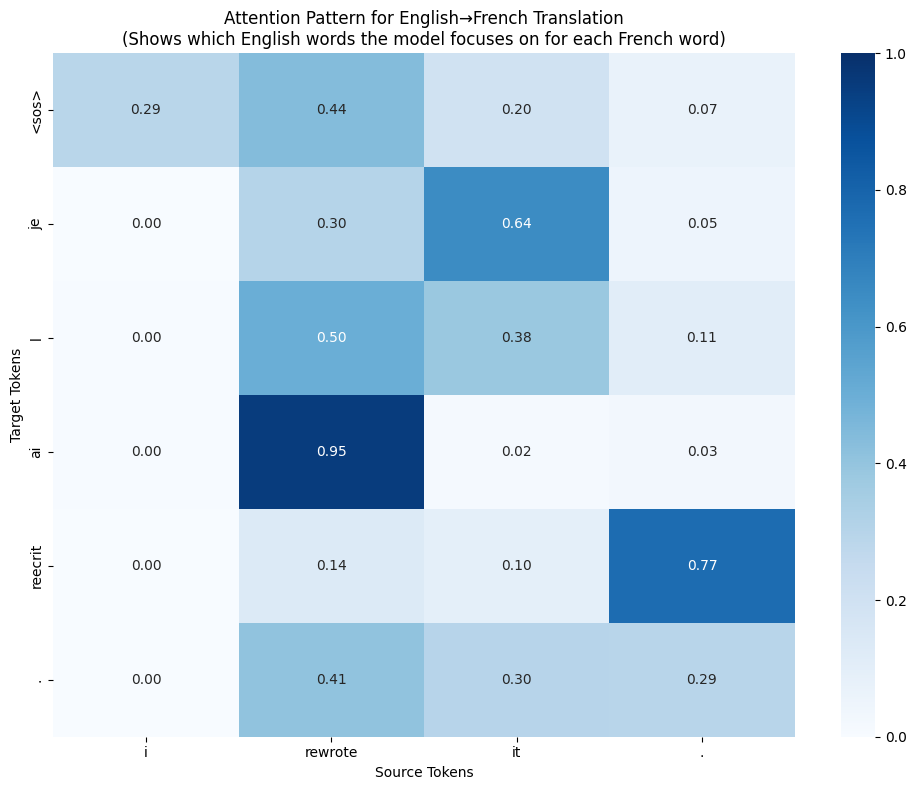


Interpretation:
  - Each row shows attention distribution when generating that French word
  - Bright cells indicate high attention (model is 'looking at' that English word)
  - Translation attention often shows diagonal patterns with some reordering


In [36]:
# Visualize the attention pattern for translation
# Limit display for visibility
max_src = min(12, len(src_tokens))
max_tgt = min(12, len(tgt_tokens))

fig = visualize_attention(
    attn_weights[:max_tgt, :max_src],
    src_tokens[:max_src],
    tgt_tokens[:max_tgt],
    title='Attention Pattern for English→French Translation\n(Shows which English words the model focuses on for each French word)'
)
plt.show()

print("\nInterpretation:")
print("  - Each row shows attention distribution when generating that French word")
print("  - Bright cells indicate high attention (model is 'looking at' that English word)")
print("  - Translation attention often shows diagonal patterns with some reordering")

### Reading the Translation Attention Heatmap Above

**The specific translation shown:**
- **Source (English):** "i rewrote it ."
- **Target (French):** "<sos> je l ai reecrit ."
- **Heatmap size:** 6×4 (6 French tokens attending to 4 English tokens)

---

**What the colors tell you:**
- **Bright cells (close to 1.0):** Strong alignment - the model is confident this French word corresponds to that English word
- **Dark cells (close to 0.0):** No relationship - the model ignores this English word for this French word
- **Medium cells (around 0.3-0.5):** Partial alignment - the French word draws from multiple English words


Visualizing Attention Patterns Across Multiple Examples


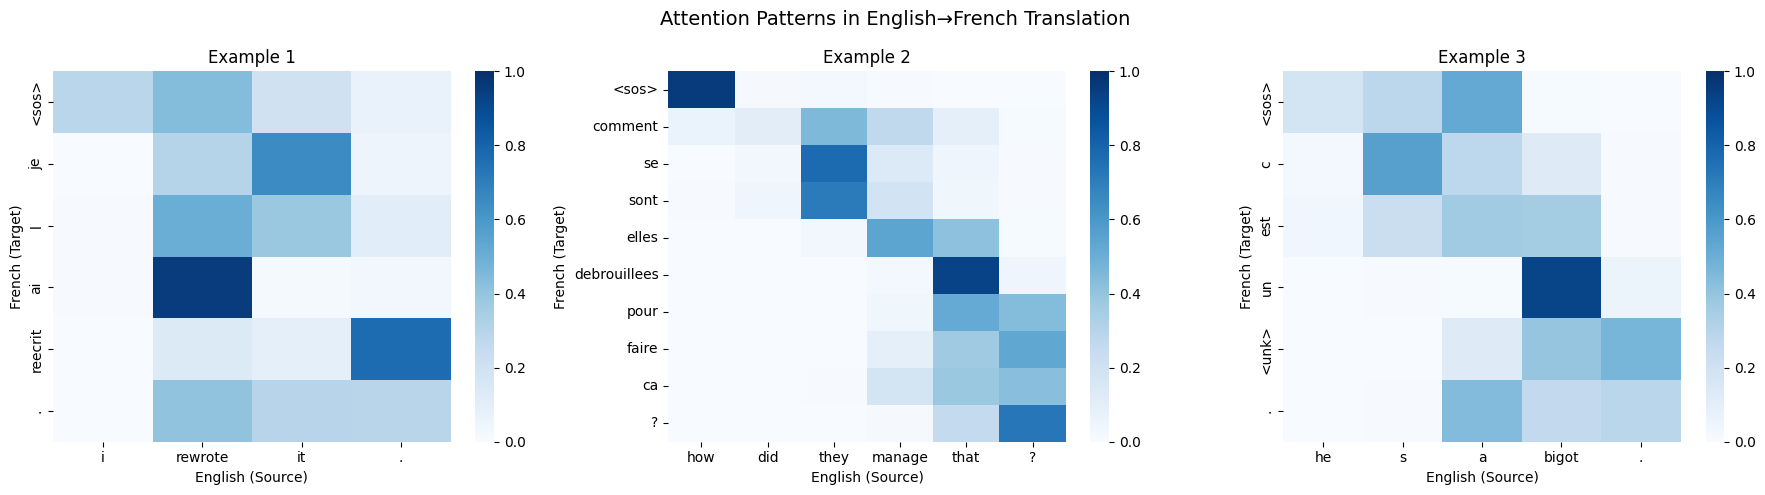

In [37]:
# Visualize attention for multiple translation examples
print("\nVisualizing Attention Patterns Across Multiple Examples")
print("="*60)

def show_translation_attention(model, dataset, eng_vocab, fra_vocab, num_examples=3):
    """Show attention heatmaps for multiple translation examples."""
    model.eval()
    
    fig, axes = plt.subplots(1, num_examples, figsize=(6*num_examples, 5))
    if num_examples == 1:
        axes = [axes]
    
    for idx in range(num_examples):
        src_indices, tgt_indices = dataset.pairs[idx]
        
        src = torch.tensor(src_indices).unsqueeze(0).to(device)
        tgt = torch.tensor(tgt_indices).unsqueeze(0).to(device)
        src_lens = torch.tensor([len(src_indices)])
        
        with torch.no_grad():
            output = model(src, tgt[:, :-1], src_lens)
        
        attn_weights = model.get_attention_weights()[0].cpu().numpy()
        
        # Decode tokens
        src_tokens = eng_vocab.decode(src_indices).split()
        tgt_tokens = ['<sos>'] + fra_vocab.decode(tgt_indices).split()
        
        # Limit for visibility
        max_len = 10
        src_tokens = src_tokens[:max_len]
        tgt_tokens = tgt_tokens[:max_len]
        attn_weights = attn_weights[:len(tgt_tokens), :len(src_tokens)]
        
        sns.heatmap(attn_weights, 
                    xticklabels=src_tokens,
                    yticklabels=tgt_tokens,
                    cmap='Blues',
                    ax=axes[idx],
                    vmin=0, vmax=1)
        axes[idx].set_xlabel('English (Source)')
        axes[idx].set_ylabel('French (Target)')
        axes[idx].set_title(f'Example {idx+1}')
    
    plt.suptitle('Attention Patterns in English→French Translation', fontsize=14)
    plt.tight_layout()
    plt.show()

show_translation_attention(model_with_attn_long, val_long, eng_vocab, fra_vocab, num_examples=3)

### Comparing the 3 Translation Heatmaps Above

**What you're seeing:**
- 3 side-by-side heatmaps, each showing a different English→French translation
- Same color scale (0 to 1) across all three for fair comparison
- Each heatmap shows which English words the model focuses on for each French word

---

**What to compare across examples:**

**1. Diagonal tendency:**
- Do all 3 show roughly diagonal patterns? (English/French have similar word order)
- Any examples with strong off-diagonal attention? (word reordering)

**2. Attention sharpness:**
- Example with sharp attention (bright single cells): Model is confident about alignment
- Example with diffuse attention (multiple medium cells per row): Word requires context from multiple sources

**3. Start token behavior:**
- First row (<sos>) typically has diffuse attention across all examples
- This is normal - no English word triggers the start token

**4. Punctuation alignment:**
- Last row (period) usually aligns with English period
- Should be consistent across examples

---

**Common patterns you might observe:**

- **Short sentences:** Tend to have sharper, more focused attention
- **Longer sentences:** May show more diffuse attention (more context needed)
- **Function words ("the", "a", "is"):** Often have spread-out attention
- **Content words (nouns, verbs):** Usually have focused alignment to their translation

In [38]:
# Visualize multi-head attention patterns
print("\nMulti-Head Attention Patterns")
print("="*60)

# Create a simple Transformer-style encoder with multi-head attention
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        self.layers = nn.ModuleList([
            MultiHeadAttention(d_model, num_heads, dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([
            nn.LayerNorm(d_model)
            for _ in range(num_layers)
        ])
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        
        for attn, norm in zip(self.layers, self.norms):
            x = norm(x + attn(x, x, x))  # Residual connection
        
        return x

# Create and forward pass using English vocabulary
encoder = SimpleTransformerEncoder(SRC_VOCAB_SIZE, d_model=64, num_heads=8, num_layers=2)
sample_input = torch.randint(4, min(100, SRC_VOCAB_SIZE), (1, 8))  # Random sequence of 8 tokens
output = encoder(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")


Multi-Head Attention Patterns
Input shape: torch.Size([1, 8])
Output shape: torch.Size([1, 8, 64])


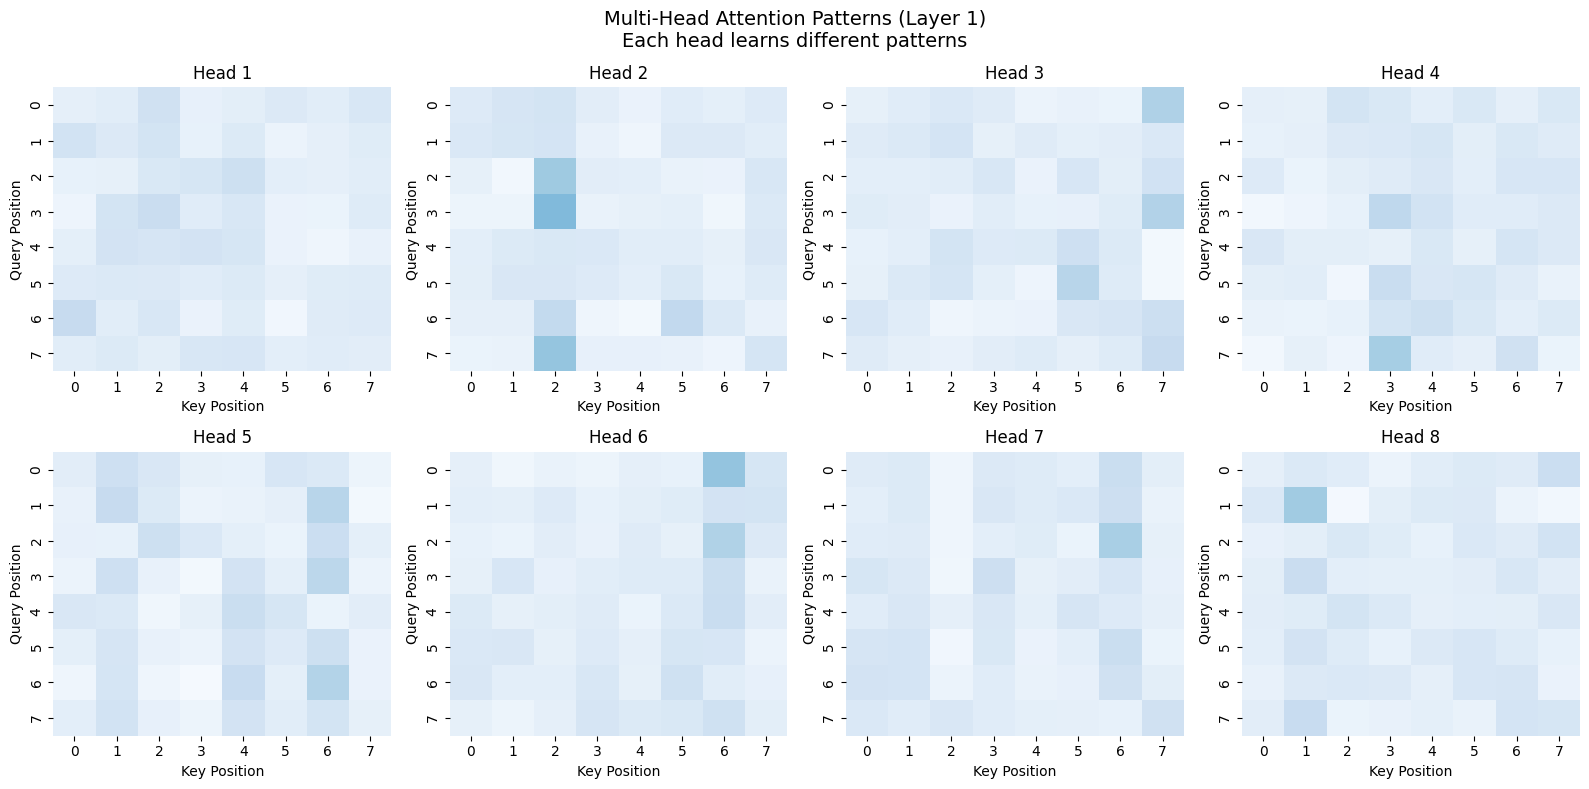


Common patterns learned by attention heads:
  - Diagonal: Attention to same position (self)
  - Adjacent: Attention to neighboring positions
  - Uniform: Broad attention across all positions
  - Specific: Strong attention to particular positions


In [39]:
# Plot attention from each head in the first layer
attn_weights = encoder.layers[0].attention_weights.detach().numpy()
attn_weights = attn_weights.reshape(8, 8, 8)  # (num_heads, seq_len, seq_len)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for head in range(8):
    sns.heatmap(attn_weights[head], 
                ax=axes[head],
                cmap='Blues',
                vmin=0, vmax=1,
                cbar=False)
    axes[head].set_title(f'Head {head + 1}')
    axes[head].set_xlabel('Key Position')
    axes[head].set_ylabel('Query Position')

plt.suptitle('Multi-Head Attention Patterns (Layer 1)\nEach head learns different patterns', fontsize=14)
plt.tight_layout()
plt.show()

print("\nCommon patterns learned by attention heads:")
print("  - Diagonal: Attention to same position (self)")
print("  - Adjacent: Attention to neighboring positions")
print("  - Uniform: Broad attention across all positions")
print("  - Specific: Strong attention to particular positions")

### Reading the 8 Transformer Encoder Head Heatmaps Above

**Figure layout:**
- 2 rows × 4 columns = 8 heatmaps (Head 1 through Head 8)
- Each heatmap is 8×8 (8 positions attending to 8 positions)
- This is SELF-attention (sequence attends to itself)
- X-axis: Key position / Y-axis: Query position

---

**What each heatmap shows:**

For a sentence like "The quick brown fox jumps over the lazy":

**Look for these patterns in each head:**

| Pattern | What it looks like | What it means |
|---------|-------------------|---------------|
| **Diagonal** | Bright line from top-left to bottom-right | Each position attends to itself |
| **Vertical stripe** | One column is bright across all rows | All positions attend to one key word |
| **Horizontal stripe** | One row is bright across all columns | One position attends broadly |
| **Off-diagonal** | Bright below/above diagonal | Attention to previous/next positions |
| **Uniform** | All cells similar brightness | No strong preferences (often in untrained models) |

---

**What to observe in THIS figure:**

Since this encoder was just initialized (not fully trained on a large corpus):
- Patterns are somewhat random/uniform
- Heads don't show clear specialization yet

**In a production Transformer (like BERT/GPT), heads typically specialize:**
- Head 1: Attends to previous token
- Head 2: Attends to sentence start
- Head 3: Attends to syntactically related words
- Head 4: Attends to semantically similar words
- etc.

**Key observation:** Even with minimal training, different heads produce DIFFERENT patterns - this is the power of multi-head attention.

---

# Exercises

---

## Exercise 1: Implement Luong (Multiplicative) Attention

Throughout this notebook, we implemented **Bahdanau Attention** (also called Additive Attention). In this exercise, you will implement **Luong Attention** (also called Multiplicative Attention), which was proposed in the paper ["Effective Approaches to Attention-based Neural Machine Translation"](https://arxiv.org/abs/1508.04025).

---

### Luong Global Attention 

The figure below shows the Luong Global Attention mechanism:

![Luong Global Attention](https://blog.paperspace.com/content/images/2022/08/globalattention.png)

*Source: [Paperspace Blog - Neural Machine Translation with Attention](https://blog.paperspace.com/introduction-to-neural-machine-translation-with-bahdanaus-attention/)*

---

### Understanding the Figure

Looking at the architecture diagram above:

1. **Bottom**: The encoder processes the source sentence and produces hidden states $\bar{h}_s$ for each source word

2. **Middle**: The attention layer computes alignment scores between the current decoder hidden state $h_t$ and all encoder hidden states

3. **Top**: The decoder uses the context vector $c_t$ (weighted sum of encoder states) along with its hidden state to predict the next word

**The key difference from Bahdanau:**
- **Bahdanau**: Uses the decoder hidden state from the *previous* timestep
- **Luong**: Uses the decoder hidden state from the *current* timestep

---

### Score Functions in Luong Attention

Luong proposes three ways to compute alignment scores:

| Name | Formula | Description |
|------|---------|-------------|
| **Dot** | $score(h_t, \bar{h}_s) = h_t^T \bar{h}_s$ | Simple dot product |
| **General** | $score(h_t, \bar{h}_s) = h_t^T W_a \bar{h}_s$ | Dot product with learned weight matrix |
| **Concat** | $score(h_t, \bar{h}_s) = v_a^T \tanh(W_a[h_t; \bar{h}_s])$ | Similar to Bahdanau |

For this exercise, implement the **General** scoring function.

---

### Your Task

Create a `LuongAttention` class that implements the **General** attention mechanism:

**What your class needs:**

1. **A weight matrix $W_a$**: This is a learnable linear layer that transforms the decoder hidden state before computing the dot product with encoder states

2. **A forward method** that:
   - Takes decoder hidden state (query) and encoder outputs (keys/values)
   - Computes scores using: $scores = query \cdot W_a \cdot keys^T$
   - Applies softmax to get attention weights (handle padding with masking)
   - Computes context vector as weighted sum of encoder outputs
   - Returns the context vector

**Test your implementation:**
- Create random tensors for queries (batch=2, seq=3, dim=8) and keys/values (batch=2, seq=5, dim=8)
- Verify attention weights sum to 1.0 for each query
- Verify masking works (set valid_lens=[5,3] and check that batch 1 has zeros in positions 3,4)

---

### References

- Original Paper: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)
- Tutorial: [Machine Learning Mastery - Luong Attention](https://machinelearningmastery.com/the-luong-attention-mechanism/)


In [ ]:
# =============================================================================
# Exercise 1: Implement Luong Attention
# =============================================================================
#
# Implement the LuongAttention class based on the architecture figure above.
# Use masked_softmax() which is already defined above in this notebook.

class LuongAttention(nn.Module):
    """
    Luong (Multiplicative/Dot-Product) Attention.

    Unlike Bahdanau which uses an additive score, Luong uses dot product:
        score = query @ key^T  (or query @ W_a @ key^T for general form)
    """
    def __init__(self, hidden_dim, dropout=0.0):
        super().__init__()
        # --------------------------------------------------
        # Step 1: Create weight matrix W_a for 'general' Luong attention
        #         This will transform keys before the dot product
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 2: Create dropout layer
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 3: Initialize attention_weights to None
        #         (for storing and visualizing later)
        # --------------------------------------------------


    def forward(self, queries, keys, values, valid_lens=None):
        """
        Args:
            queries: (batch, num_queries, hidden_dim)
            keys: (batch, num_keys, hidden_dim)
            values: (batch, num_keys, hidden_dim)
            valid_lens: (batch,) - for masking padding

        Returns:
            context: (batch, num_queries, hidden_dim)
        """
        # --------------------------------------------------
        # Step 1: Transform keys using W_a
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 2: Compute attention scores
        #         Hint: use torch.bmm for batch matrix multiply
        #         scores shape should be (batch, num_queries, num_keys)
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 3: Apply masked_softmax to get attention weights
        #         Store in self.attention_weights for visualization
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 4: Apply dropout to the weights
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 5: Compute context as weighted sum of values
        #         Return the context vector
        # --------------------------------------------------




# =============================================================================
# Test your implementation
# =============================================================================

# batch, num_q, num_k, d = 2, 3, 5, 8
# queries = torch.randn(batch, num_q, d)
# keys = torch.randn(batch, num_k, d)
# values = torch.randn(batch, num_k, d)
# valid_lens = torch.tensor([5, 3])
#
# luong = LuongAttention(d)
# output = luong(queries, keys, values, valid_lens)
# print(f"Output shape: {output.shape}")  # Expected: (2, 3, 8)
# print(f"Weights sum: {luong.attention_weights.sum(dim=-1)}")  # Should be all 1.0


# =============================================================================
# Integrate into Seq2Seq and Train
# =============================================================================
#
# After implementing LuongAttention, create a full translation model.
#
# Already defined above (just call them):
#   - Encoder class
#   - train_seq2seq() function
#   - train_loader_long, val_loader_long
#   - eng_vocab, fra_vocab
#
# YOUR TASK:
# 1. Create DecoderWithLuongAttention (look at DecoderWithAttention for reference)
# 2. Create Seq2SeqWithLuongAttention
# 3. Train and compare with Bahdanau results


---

## Exercise 2: Implement BERT-Style Self-Attention

In this exercise, you will implement **self-attention** as used in BERT and other Transformer models. Unlike the encoder-decoder attention we implemented earlier (where queries come from decoder and keys/values from encoder), self-attention has queries, keys, and values all derived from the **same input sequence**.

---

### Self-Attention in Transformers

The figure below from ["The Illustrated Transformer"](https://jalammar.github.io/illustrated-transformer/) shows how self-attention works:

![Self-Attention Matrix Calculation](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

*Source: [The Illustrated Transformer by Jay Alammar](https://jalammar.github.io/illustrated-transformer/)*

---

### Step-by-Step Process

**Step 1: Create Q, K, V from input**

![QKV Vectors](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

Each input embedding is multiplied by three weight matrices to create Query, Key, and Value vectors.

---

**Step 2: Calculate attention scores**

![Score Calculation](https://jalammar.github.io/images/t/transformer_self_attention_score.png)

Score = Query · Key^T, then divide by √d_k for stability.

---

**Step 3: Apply softmax and multiply by Values**

![Softmax and Output](https://jalammar.github.io/images/t/self-attention-output.png)

Apply softmax to scores, then compute weighted sum of Value vectors.

---

### The Complete Self-Attention Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- $Q = XW^Q$ (queries)
- $K = XW^K$ (keys)
- $V = XW^V$ (values)
- $X$ is the input sequence (same for Q, K, V in self-attention)
- $d_k$ is the dimension of keys (for scaling)

---

### Multi-Head Self-Attention

BERT uses **multi-head attention** where multiple attention operations run in parallel:

![Multi-Head Attention](https://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)

Each head can learn to focus on different types of relationships (syntax, semantics, position, etc.)

---

### Your Task

Implement a `BertSelfAttention` class that performs self-attention on an input sequence:

**What your class needs:**

1. **Three projection layers**: $W^Q$, $W^K$, $W^V$ to create queries, keys, values from input

2. **An output projection**: $W^O$ to project the concatenated heads back to model dimension

3. **Forward method** that:
   - Takes input $X$ of shape (batch, seq_len, hidden_dim)
   - Projects to Q, K, V using the weight matrices
   - Computes scaled dot-product attention: $\text{softmax}(QK^T / \sqrt{d_k})V$
   - Returns output of same shape as input

**Bonus**: Implement multi-head attention by:
- Splitting Q, K, V into multiple heads
- Computing attention for each head independently
- Concatenating and projecting back

---

### Test Your Implementation

```python
# Input: batch of 2 sequences, each with 6 tokens, embedding dim 64
x = torch.randn(2, 6, 64)

# Self-attention
self_attn = BertSelfAttention(hidden_dim=64, num_heads=8)
output = self_attn(x)

# Verify:
# - output.shape should equal x.shape (2, 6, 64)
# - attention_weights.shape should be (2, 6, 6) for single head
#   or (2, 8, 6, 6) for multi-head
```

---

### References

- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) - Excellent visual explanation
- [BERT Paper](https://arxiv.org/abs/1810.04805) - Original BERT paper
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - Original Transformer paper


In [ ]:
# =============================================================================
# Exercise 2: Implement BERT-Style Self-Attention
# =============================================================================
#
# Implement BertSelfAttention class based on the figures above.
# Key insight: Q, K, V all come from the SAME input (that's why it's "self" attention)

class BertSelfAttention(nn.Module):
    """
    Self-Attention as used in BERT and Transformers.

    In self-attention, queries, keys, and values all come from the same input.
    This allows each position to attend to all other positions in the sequence.
    """
    def __init__(self, hidden_dim, num_heads=1, dropout=0.0):
        super().__init__()
        # --------------------------------------------------
        # Step 1: Store hidden_dim and num_heads
        #         Calculate head_dim = hidden_dim // num_heads
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 2: Create three projection layers for Q, K, V
        #         (Look at the figure - each has its own weight matrix)
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 3: Create output projection layer W_o
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 4: Create dropout layer and initialize
        #         attention_weights to None
        # --------------------------------------------------


    def forward(self, x, mask=None):
        """
        Args:
            x: (batch, seq_len, hidden_dim) - input sequence
            mask: optional mask for padding

        Returns:
            output: (batch, seq_len, hidden_dim)
        """
        # --------------------------------------------------
        # Step 1: Project input x to get Q, K, V
        #         Remember: all three come from the SAME x
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 2: Compute attention scores (Q @ K^T)
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 3: Scale the scores by sqrt(d_k)
        #         This prevents large dot products from
        #         pushing softmax into saturated regions
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 4: Apply mask if provided
        #         (Set masked positions to -inf before softmax)
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 5: Apply softmax to get attention weights
        #         Store in self.attention_weights
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 6: Apply dropout and compute weighted sum of V
        # --------------------------------------------------


        # --------------------------------------------------
        # Step 7: Apply output projection and return
        # --------------------------------------------------




# =============================================================================
# Test your implementation
# =============================================================================

# x = torch.randn(2, 6, 64)
# self_attn = BertSelfAttention(hidden_dim=64, num_heads=1)
# output = self_attn(x)
# print(f"Input shape: {x.shape}")
# print(f"Output shape: {output.shape}")  # Should be (2, 6, 64)


# =============================================================================
# BONUS: Multi-Head Attention
# =============================================================================
#
# Modify your implementation to support multiple heads:
# - Reshape Q, K, V to separate the heads dimension
# - Compute attention for all heads in parallel
# - Concatenate heads and project with W_o


# =============================================================================
# Visualize Self-Attention
# =============================================================================

# tokens = ["The", "cat", "sat", "on", "the", "mat"]
# x = torch.randn(1, 6, 64)
# self_attn = BertSelfAttention(hidden_dim=64, num_heads=1)
# _ = self_attn(x)
#
# plt.figure(figsize=(8, 6))
# sns.heatmap(self_attn.attention_weights[0].detach().numpy(),
#             xticklabels=tokens, yticklabels=tokens, cmap='Blues')
# plt.title('Self-Attention: What does each word attend to?')
# plt.show()


### Visualizing Self-Attention Patterns

After implementing your self-attention, visualize what different positions attend to:

```python
# Create input with meaningful tokens
tokens = ["The", "cat", "sat", "on", "the", "mat"]
x = torch.randn(1, 6, 64)  # Pretend embeddings

# Get attention weights
self_attn = BertSelfAttention(hidden_dim=64, num_heads=1)
_ = self_attn(x)
attn = self_attn.attention_weights[0].detach().numpy()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens,
            annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Key (attending TO)')
plt.ylabel('Query (attending FROM)')
plt.title('Self-Attention Pattern')
plt.show()
```

### Questions to Consider

1. In self-attention, what does it mean when a word attends to itself (diagonal)?

2. Why do we divide by $\sqrt{d_k}$ before softmax?

3. How does multi-head attention help compared to single-head?

4. What is the computational complexity of self-attention with respect to sequence length?


---

# Summary

In this notebook, we explored the **attention mechanism**, a fundamental component of modern deep learning:

## Key Takeaways

1. **Attention solves the bottleneck problem** in seq2seq models by allowing the decoder to access all encoder states, not just the final one. This is especially important for long sequences.

2. **Query-Key-Value framework** provides a unified way to think about attention:
   - Query: What you're looking for
   - Key: What you match against
   - Value: What you retrieve

3. **Context vectors** are weighted sums of values, where weights are determined by query-key similarity. They dynamically focus on relevant information.

4. **Multi-head attention** allows the model to attend to different types of relationships simultaneously by using parallel attention heads.

5. **Positional encoding** is essential when using attention without RNNs, as attention is permutation-invariant and cannot distinguish token order.

6. **Attention visualization** reveals what the model has learned and helps interpret its behavior.